# ARR Analysis

## Goal

ARR prediction, where ARR=RoomIncome_Main/room_nights

## Roadmap

1. Load dataset
- Features Engineering (+Cleaning)
- Exploratory Data Analysis (EDA)
    - High level statistics
    - Features Histograms
    - Data Encoding (categorigal+numeric)
    - Correlation Matrix
- Basic Modelling
    - Linear Regression
    - Ridge (L2)
    - Lasso (L1)
    - Elastic-Net (L1+L2)
    - Support Vector Regression (SVR)
- Trees
    - Decision Trees
    - Random Forest (ensemble)
    - XGBoost (boosted)
- Neural Networks
    - Multi-layer Perceptron
    - LSTM RNN (Tensorflow)
    - LSTM AutoEncoder (Tensorflow)
- Statistical Forcasting
    - SARIMAX
    - FBProphet
 
<br><br>
<div><img src="https://miro.medium.com/max/1400/1*OmxKKDqcVm_UCOYT9i5TJw.png" width=750"/></div>

<hr>

# Initialization

Import required libraries

In [1]:
import glob
import json
import shap
import pylab
import codecs
import joblib
import datetime
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
import statsmodels.api as sm
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from os import path, environ
from fbprophet import Prophet
from sklearn.svm import LinearSVR
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.inspection import plot_partial_dependence, permutation_importance
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score, GridSearchCV
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima

tf.logging.set_verbosity(tf.logging.ERROR)
sns.set(color_codes=True)

pylab.rcParams['figure.figsize'] = (60.0, 20.0)
pylab.rcParams['font.size'] = 14
pylab.rcParams['figure.max_open_warning'] = 0

sns.set(); sns.reset_defaults

%matplotlib inline

print("tensorflow version: %s" % str(tf.__version__))

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


tensorflow version: 1.14.0


User Parameters:

In [2]:
dataset_path = "../EDA/data/res*.csv"
events_path = "../EDA/events.xls"
avail_path = "../EDA/Availability/*.txt"
plangrp_path = '../EDA/plan_grouping.xlsx'

save_path = 'saved_data/'
scaling_mode = "standard"
hyper_params_en = False
overwrite_saved_data = False

index_var = 'res_date'
dependent_var ='ARR'

m_lead_days_max = 300
room_nights_min = 0
room_nights_max = 7
RoomIncome_Main_min = 0
RoomIncome_Main_max = 4000
dependent_var_max = 3000
cv_ratio = 0.2
singles_only = False
fulfilled_only = False

models = ['linear_regressor',       # 0
          'ridge_regressor',        # 1
          'lasso_regressor',        # 2
          'elasticnet_regressor',   # 3
          'supportvect_regressor',  # 4 
          'decisiontree_regressor', # 5
          'randomforest_regressor', # 6
          'xgboost_regressor',      # 7
          'mlp_regressor',          # 8
          'lstm_rnn',               # 9
          'lstm_autoencoder',       # 10
          'sarima',                 # 11
          'fbprophet']              # 12

External parameters:

In [3]:
if not 'hotel_sel' in locals():
    hotel_sel = 546.0 

Load reservations dataset

In [4]:
all_files = glob.glob(dataset_path)

li = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0, low_memory=False)
    li.append(df)

reservations_data = pd.concat(li, axis=0, ignore_index=True)

In [5]:
reservations_data.head()

,res_date,hotel,master,res,wing,group_member,nationality,m_length_of_stay,bed_nights,room_nights,...,Cxl_Reason_code,CXL_LeadDays,adults,juniors,children,babies,club_code,StatisticSource,Commission_Main,Commission_Second
0,2018-11-12,543.0,78005.0,1.0,1.0,1.0,usa,11.0,1.0,0.5,...,NaN,NaN,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
1,2018-11-09,543.0,78006.0,1.0,1.0,1.0,usa,11.0,1.0,0.5,...,NaN,NaN,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2,2018-11-10,543.0,78006.0,1.0,1.0,1.0,usa,11.0,1.0,0.5,...,NaN,NaN,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
3,2018-11-06,543.0,78006.0,1.0,1.0,1.0,usa,11.0,1.0,0.5,...,NaN,NaN,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
4,2018-11-11,543.0,78006.0,1.0,1.0,1.0,usa,11.0,1.0,0.5,...,NaN,NaN,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN


In [6]:
hotels = reservations_data['hotel'].unique()
hotels = np.sort(hotels[~np.isnan(hotels)])
print('Hotels:\n%s\n' % str(hotels))
print('Selected: %s\n' % str(hotel_sel))

Hotels:
[542. 543. 545. 546. 547. 548. 549. 550. 551. 552. 554. 555. 643. 956.
 957. 960.]

Selected: 546.0



Load special events

events_df (230, 7)


,FairId,FairName,FromDate,ToDate,HotelId,Unnamed: 5,OFFICE
0,1,פסטיבל הג'אז חורף אילת,2016-02-11,2016-02-12,554,NaN,1
1,1,פסטיבל הג'אז חורף אילת,2016-02-11,2016-02-12,555,NaN,1
2,1,פסטיבל הג'אז חורף אילת,2016-02-11,2016-02-12,960,NaN,1
3,1,פסטיבל הג'אז חורף אילת,2017-02-09,2017-02-10,554,NaN,1
4,1,פסטיבל הג'אז חורף אילת,2017-02-09,2017-02-10,555,NaN,1


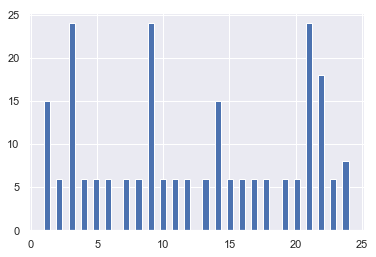

In [7]:
events_df = pd.read_excel(events_path)

print('events_df', events_df.shape)
display(events_df.head())
events_df.FairId.hist(bins=50)

Load Availability

availability_df (1095, 4)


,date_taken,AvailRooms,hotel_rooms,capacity
2462028,2017-01-02,208.0,208.0,1.0
2458465,2017-01-03,208.0,208.0,1.0
2456486,2017-01-04,208.0,208.0,1.0
2462031,2017-01-05,208.0,208.0,1.0
2456488,2017-01-06,208.0,208.0,1.0


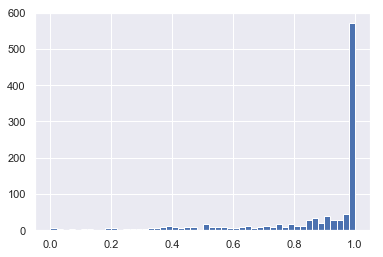

In [8]:
all_files = glob.glob(avail_path)

li = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0, low_memory=False, sep=',', encoding='utf-16')
    li.append(df)

availability_df = pd.concat(li, axis=0, ignore_index=True)

availability_df['date_taken'] = availability_df['date_taken'].astype(str)

availability_df['capacity'] = availability_df['AvailRooms'] / availability_df['hotel_rooms']
availability_df['capacity'] = availability_df['capacity'].clip(lower=0)

availability_df = availability_df[availability_df['hotel'] == hotel_sel].drop('hotel', axis=1)
availability_df = availability_df.drop('res_date', axis=1).sort_values('date_taken')
availability_df = availability_df.drop_duplicates(subset='date_taken', keep='last')

print('availability_df', availability_df.shape)
display(availability_df.head())
availability_df['capacity'].hist(bins=50)

Load Plan Grouping

In [9]:
plan_grouping_df = pd.read_excel(plangrp_path)
plan_grouping_df.columns = [*plan_grouping_df.columns[:-1], 'plan_code']

print('plan_grouping_df', plan_grouping_df.shape)
display(plan_grouping_df.head())

plan_grouping_df (43, 3)


,Plan_bi_id,plan_desc,plan_code
0,1,half board,HB
1,2,breakfest arr day+hb,HB+
2,3,fb dinner arr day+dinner next,FB+
3,4,fb+lounge,FB
4,5,breakfast board,BB


<hr>

# Features Engineering (+Cleaning)

Focus on relevant attributes + Cleaning

In [10]:
reservations_data2 = reservations_data.copy()

# Focus on a specific hotel:
reservations_data2 = reservations_data2[reservations_data2['hotel'] == hotel_sel]

reservations_data2['date_taken'] = pd.to_datetime(reservations_data2['Date_taken'], errors='coerce')
reservations_data2['date_taken'] = reservations_data2['date_taken'].dt.date.astype(str)

# Clean (filter):
reservations_data2 = reservations_data2[(reservations_data2['m_lead_days']<m_lead_days_max) &
                                        (reservations_data2['room_nights']>room_nights_min) & 
                                        (reservations_data2['room_nights']<room_nights_max) &
                                        (reservations_data2['RoomIncome_Main']>RoomIncome_Main_min) &
                                        (reservations_data2['RoomIncome_Main']<RoomIncome_Main_max)]

# Keep only Singles reservations:
if singles_only:
    singles_ids = [1, 4, 6, 11, 15, 21, 30, 31, 34]
    reservations_data2 = reservations_data2[reservations_data2['market_segment_bi_id'].isin(singles_ids)]

# Keep only fulfilled reservations:
if fulfilled_only:
    fulfilled_ids = ['arriv', 'chkin', 'chkou', 'res']
    reservations_data2 = reservations_data2[reservations_data2['reservation_status'].isin(fulfilled_ids)]

# Extract relevant features only:
reservations_data2 = reservations_data2[['res_date',
                                         'RoomTypes_desc',
                                         'market_segment_bi_id',
                                         'MainCust',
                                         'source',
                                         'sales_channel',
                                         'club_code',
                                         'StatisticSource',
                                         'package_code',
                                         'nationality',
                                         'group_member',
                                         'm_length_of_stay',
                                         'bed_nights',
                                         'm_lead_days',
                                         'adults',
                                         'juniors',
                                         'children',
                                         'babies',
                                         'plan_desc',                                         
                                         'RoomIncome_Main',
                                         'room_nights',
                                         'date_taken']]

# Add 'event_id' sideband feature (for specific hotel):
index_var_dt = pd.to_datetime(reservations_data2[index_var], errors='coerce')
s = index_var_dt.values[:,None]
s1 = events_df['HotelId'].values
s2 = events_df['FromDate'].values
s3 = events_df['ToDate'].values
reservations_data2['event_id'] = (np.dot(((s1==hotel_sel)|(s1==0))&(s>=s2)&(s<=s3), events_df.FairId))
reservations_data2['event_id'] = reservations_data2['event_id'].astype(str)

# Add 'day_of_week' feature:
reservations_data2['day_of_week'] = index_var_dt.dt.day_name()

# Add Availability feature (for specific hotel)
reservations_data2 = pd.merge(reservations_data2, 
                              availability_df[['date_taken','capacity']], 
                              on='date_taken',
                              how='left')
reservations_data2['capacity'] = reservations_data2['capacity'].fillna(1.0)
reservations_data2 = reservations_data2.drop(['date_taken'], axis=1)

# Add Plan Code feature:
reservations_data2 = pd.merge(reservations_data2, 
                              plan_grouping_df[['plan_desc','plan_code']], 
                              on='plan_desc', 
                              how='left')
reservations_data2 = reservations_data2.drop(['plan_desc'], axis=1)

# Mark categorigal features:
reservations_data2['market_segment_bi_id'] = reservations_data2['market_segment_bi_id'].astype(str)

# Dependent variable:
reservations_data2[dependent_var] = (reservations_data2['RoomIncome_Main'] / reservations_data2['room_nights']).fillna(0)
reservations_data2 = reservations_data2.drop(['RoomIncome_Main', 'room_nights'], axis=1)

# MA features:
reservations_data2['ma14'] = reservations_data2[dependent_var].groupby(reservations_data2.index).mean().rolling(window=14).mean()
reservations_data2['ma100'] = reservations_data2[dependent_var].groupby(reservations_data2.index).mean().rolling(window=100).mean()

# Additional cleanup (dependent variable related):
reservations_data2 = reservations_data2[(reservations_data2[dependent_var] < dependent_var_max)]

Reservation dataframe finalization:

In [11]:
# Reservations dataframe finalization
reservations_df = reservations_data2.copy()
reservations_df[index_var] = pd.to_datetime(reservations_df[index_var])
reservations_df = reservations_df.set_index(index_var)
reservations_df = reservations_df.sort_index()
reservations_df = reservations_df.drop_duplicates()

# Add a synthetic time (unique)
reservations_df = reservations_df.set_index(pd.to_datetime(reservations_df.index) + 
                                            pd.to_timedelta(reservations_df.groupby(level=0).cumcount(), unit='s'))

Data Cleaning (fillna, per column)

In [12]:
for col in reservations_df:
    dt = reservations_df[col].dtype 
    if dt == int or dt == float:
        reservations_df[col] = reservations_df[col].fillna(0)
    else:
        reservations_df[col] = reservations_df[col].fillna("")

Debug mixed types cases

In [13]:
%%script false --no-raise-error

df = pd.DataFrame(reservations_df['nationality'])
weird = (df.applymap(type) != df.iloc[0].apply(type)).any(axis=1)
display(df[weird])

<hr>

# Data Exploration ("mini-EDA")

### Quick look:

In [14]:
print('reservations_df shape: %s' % str(reservations_df.shape))
display(reservations_df.head())

reservations_df shape: (83885, 24)


,RoomTypes_desc,market_segment_bi_id,MainCust,source,sales_channel,club_code,StatisticSource,package_code,nationality,group_member,...,juniors,children,babies,event_id,day_of_week,capacity,plan_code,ARR,ma14,ma100
2018-01-01 00:00:00,deluxe pool view,4.0,8587.0,t.a.,home site,,,,rus,0.0,...,0.0,0.0,0.0,0,Monday,0.711538,BB,1135.30,1462.940714,1406.7018
2018-01-01 00:00:01,deluxe pool view,4.0,8587.0,t.a.,home site,,,,rus,0.0,...,0.0,0.0,0.0,0,Monday,0.711538,BB,1135.30,1695.742143,1391.9246
2018-01-01 00:00:02,deluxe suite,4.0,12346.0,slf,,,,,isr,0.0,...,0.0,0.0,1.0,0,Monday,0.706731,BB,2519.78,1128.500000,986.5330
2018-01-01 00:00:03,herzliya room,4.0,9219.0,t.a.,,platinum,,,usa,0.0,...,0.0,0.0,0.0,0,Monday,0.923077,BB,1048.54,797.759286,885.2308
2018-01-01 00:00:04,deluxe sea view,15.0,9701.0,co,,platinum,,,isr,0.0,...,0.0,0.0,0.0,0,Monday,0.975962,BB,745.40,796.882143,764.8939


In [15]:
reservations_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 83885 entries, 2018-01-01 00:00:00 to 2019-12-31 00:00:37
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   RoomTypes_desc        83885 non-null  object 
 1   market_segment_bi_id  83885 non-null  object 
 2   MainCust              83885 non-null  float64
 3   source                83885 non-null  object 
 4   sales_channel         83885 non-null  object 
 5   club_code             83885 non-null  object 
 6   StatisticSource       83885 non-null  object 
 7   package_code          83885 non-null  object 
 8   nationality           83885 non-null  object 
 9   group_member          83885 non-null  float64
 10  m_length_of_stay      83885 non-null  float64
 11  bed_nights            83885 non-null  float64
 12  m_lead_days           83885 non-null  float64
 13  adults                83885 non-null  float64
 14  juniors               83885 non-nul

Dependent variable overview:

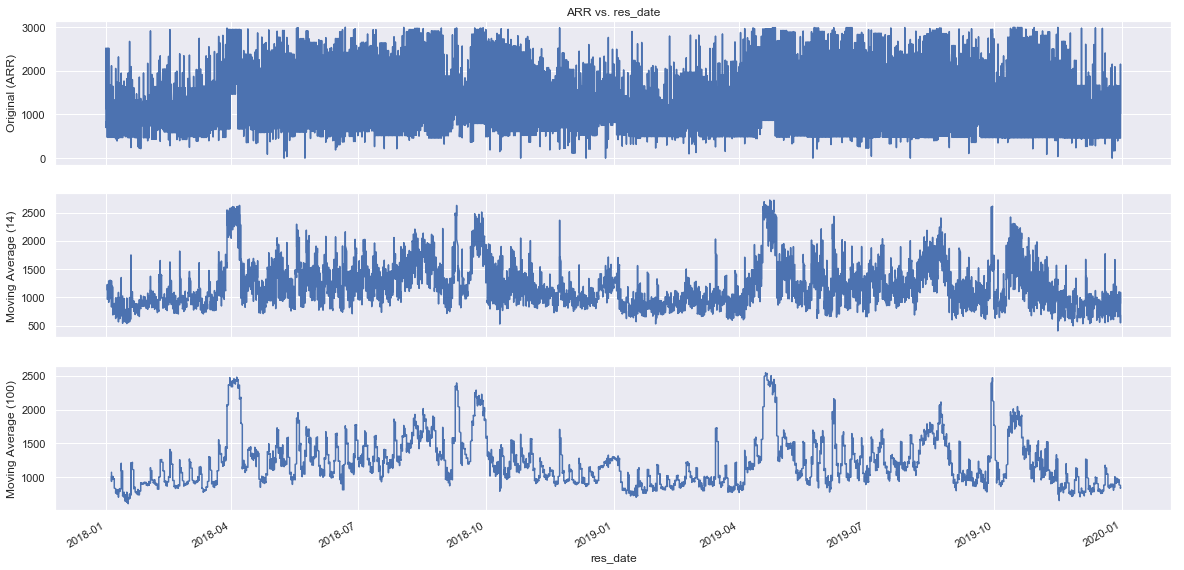

In [16]:
x = reservations_df.index.unique()
y1 = reservations_df[dependent_var].groupby(reservations_df.index).mean()
y2 = reservations_df[dependent_var].groupby(reservations_df.index).mean().rolling(window=14).mean()
y3 = reservations_df[dependent_var].groupby(reservations_df.index).mean().rolling(window=100).mean()

fig, ax = plt.subplots(3,1,figsize=(20,10), sharex=True)
ax[0].plot(x, y1)
ax[1].plot(x, y2)
ax[2].plot(x, y3)
ax[2].xaxis_date()
fig.autofmt_xdate()
ax[2].set_xlabel(index_var)
ax[0].set_ylabel('Original (%s)' % dependent_var)
ax[1].set_ylabel('Moving Average (14)')
ax[2].set_ylabel('Moving Average (100)')
ax[0].set_title('%s vs. %s' % (dependent_var,index_var))
plt.show()

### Encode the dataset

In [17]:
encoded_pre_df = reservations_df.drop([dependent_var], axis=1)

# Label Encoding:
enc_lbl = LabelEncoder()
encoded_categorical_df = encoded_pre_df.select_dtypes(include=['object']).apply(enc_lbl.fit_transform)

# OneHot Encoding:
enc_oh = OneHotEncoder(handle_unknown='ignore')
encoded_categorical_oh_df = pd.DataFrame(enc_oh.fit_transform(encoded_categorical_df).toarray(), 
                                         index=reservations_df.index)
encoded_categorical_oh_df.columns = enc_oh.get_feature_names(encoded_categorical_df.columns)

# Numerical Features:
encoded_numerical_df = encoded_pre_df.select_dtypes(exclude=['object'])

# Merge back into a single dataframe:
encoded_df = pd.concat([encoded_categorical_oh_df, encoded_numerical_df], axis=1, sort=False)
    
print('Features (after encoding):\n')
print(encoded_df.shape)
display(encoded_df.head())
display(encoded_df.describe())

Features (after encoding):

(83885, 247)


,RoomTypes_desc_0,RoomTypes_desc_1,RoomTypes_desc_2,RoomTypes_desc_3,RoomTypes_desc_4,RoomTypes_desc_5,RoomTypes_desc_6,RoomTypes_desc_7,RoomTypes_desc_8,RoomTypes_desc_9,...,m_length_of_stay,bed_nights,m_lead_days,adults,juniors,children,babies,capacity,ma14,ma100
2018-01-01 00:00:00,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.0,1.0,36.0,1.0,0.0,0.0,0.0,0.711538,1462.940714,1406.7018
2018-01-01 00:00:01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.0,1.0,36.0,1.0,0.0,0.0,0.0,0.711538,1695.742143,1391.9246
2018-01-01 00:00:02,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,11.0,2.0,2.0,2.0,0.0,0.0,1.0,0.706731,1128.500000,986.5330
2018-01-01 00:00:03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,7.0,1.0,0.0,1.0,0.0,0.0,0.0,0.923077,797.759286,885.2308
2018-01-01 00:00:04,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,3.0,1.0,1.0,1.0,0.0,0.0,0.0,0.975962,796.882143,764.8939


,RoomTypes_desc_0,RoomTypes_desc_1,RoomTypes_desc_2,RoomTypes_desc_3,RoomTypes_desc_4,RoomTypes_desc_5,RoomTypes_desc_6,RoomTypes_desc_7,RoomTypes_desc_8,RoomTypes_desc_9,...,m_length_of_stay,bed_nights,m_lead_days,adults,juniors,children,babies,capacity,ma14,ma100
count,83885.000000,83885.000000,83885.000000,83885.000000,83885.000000,83885.000000,83885.000000,83885.000000,83885.000000,83885.000000,...,83885.000000,83885.000000,83885.000000,83885.000000,83885.000000,83885.000000,83885.000000,83885.000000,83885.000000,83885.000000
mean,0.000012,0.002480,0.054944,0.041259,0.160386,0.001073,0.013614,0.070799,0.655421,0.000012,...,5.249997,1.545783,39.414138,1.386446,0.000072,0.159266,0.037718,0.820335,1231.024567,1238.997442
std,0.003453,0.049734,0.227873,0.198890,0.366966,0.032738,0.115882,0.256491,0.475234,0.003453,...,4.968510,0.717312,54.600024,0.568573,0.008457,0.527036,0.200336,0.238093,488.675572,397.284972
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,1.000000,6.000000,1.000000,0.000000,0.000000,0.000000,0.725962,875.155714,959.076500
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,4.000000,1.000000,17.000000,1.000000,0.000000,0.000000,0.000000,0.923077,1080.895714,1136.028200
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,7.000000,2.000000,45.000000,2.000000,0.000000,0.000000,0.000000,1.000000,1498.570000,1412.215900
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,96.000000,4.000000,298.000000,4.000000,1.000000,4.000000,3.000000,1.000000,3455.047143,2796.844600


### Histogram Analysis

Dependent variable histogram

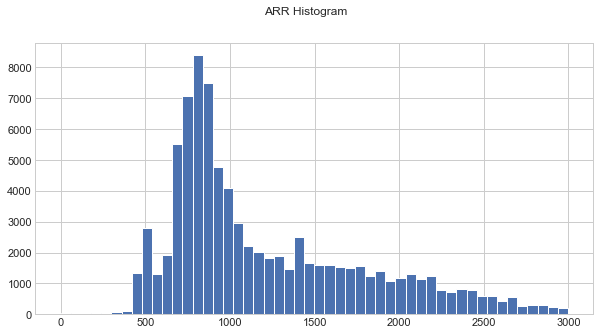

ARR min, mean, max = 0.01, 1208.24, 2997.72
ARR uniques (10723):
 [1.00000e-02 3.00000e-02 2.70000e-01 ... 2.99442e+03 2.99733e+03
 2.99772e+03]


In [18]:
plt.style.use('seaborn-whitegrid')
reservations_data2[dependent_var].hist(bins=50, figsize=(10,5))
plt.suptitle('%s Histogram' % dependent_var)
plt.show()

s = reservations_data2[dependent_var]
s_unique = np.sort(s.unique())
print('%s min, mean, max = %.2f, %.2f, %.2f' % (dependent_var,min(s),np.mean(s),max(s)))
print('%s uniques (%d):\n %s' % (dependent_var, len(s_unique), str(s_unique)))

Features Histograms

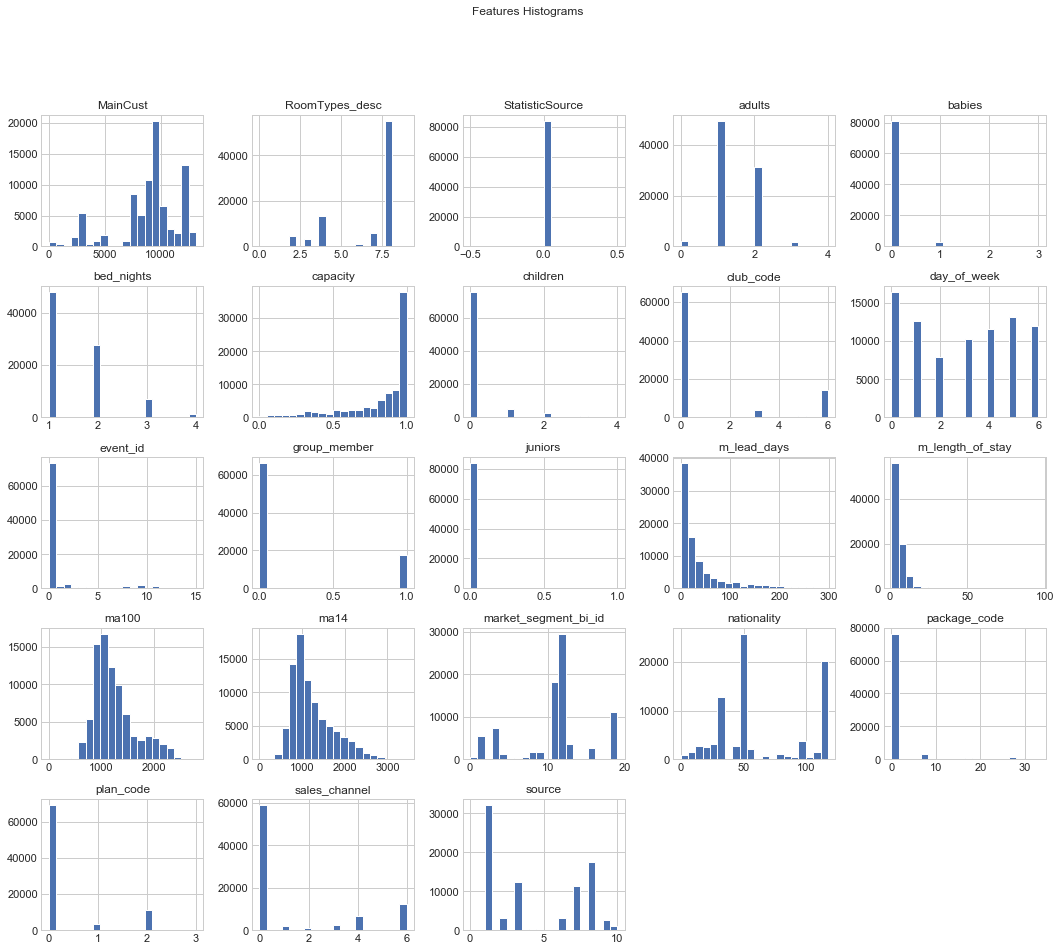

In [19]:
plt.style.use('seaborn-whitegrid')
encoded_hist_df = pd.concat([encoded_categorical_df, encoded_numerical_df], axis=1, sort=False)
encoded_hist_df.hist(bins=20, figsize=(18,15))
plt.suptitle('Features Histograms')
plt.show()

### Correlation Matrix

A correlation matrix is a table showing correlation coefficients between variables. Each cell in the table shows the correlation between two variables.<br>
The __Pearson__ and __Spearman__ correlation coefficients can range in value from −1 to +1 ([link](https://support.minitab.com/en-us/minitab-express/1/help-and-how-to/modeling-statistics/regression/supporting-topics/basics/a-comparison-of-the-pearson-and-spearman-correlation-methods/)).<br>
The __Pearson__ correlation evaluates the __linear__ relationship between two continuous variables.<br>
The __Spearman__ correlation evaluates the __monotonic__ relationship between two continuous or ordinal variables.

In [20]:
dependent_series = reservations_df[dependent_var]
encoded_df2 = pd.concat([encoded_df, dependent_series], axis=1)

Relevant Features (Pearson):

event_id_1                 0.207286
sales_channel_6            0.247440
source_3                   0.247790
event_id_0                 0.264649
RoomTypes_desc_2           0.270021
club_code_6                0.275054
package_code_0             0.275981
market_segment_bi_id_19    0.286196
market_segment_bi_id_3     0.307727
club_code_0                0.311073
source_7                   0.339389
children                   0.342838
source_8                   0.366959
sales_channel_4            0.382588
adults                     0.437007
market_segment_bi_id_12    0.447852
RoomTypes_desc_7           0.465922
source_1                   0.486615
ma100                      0.559470
bed_nights                 0.598211
RoomTypes_desc_8           0.599841
market_segment_bi_id_11    0.600562
ma14                       0.712794
ARR                        1.000000
Name: ARR, dtype: float64 

Relevant Features (Spearman):

plan_code_0                0.207220
event_id_0 

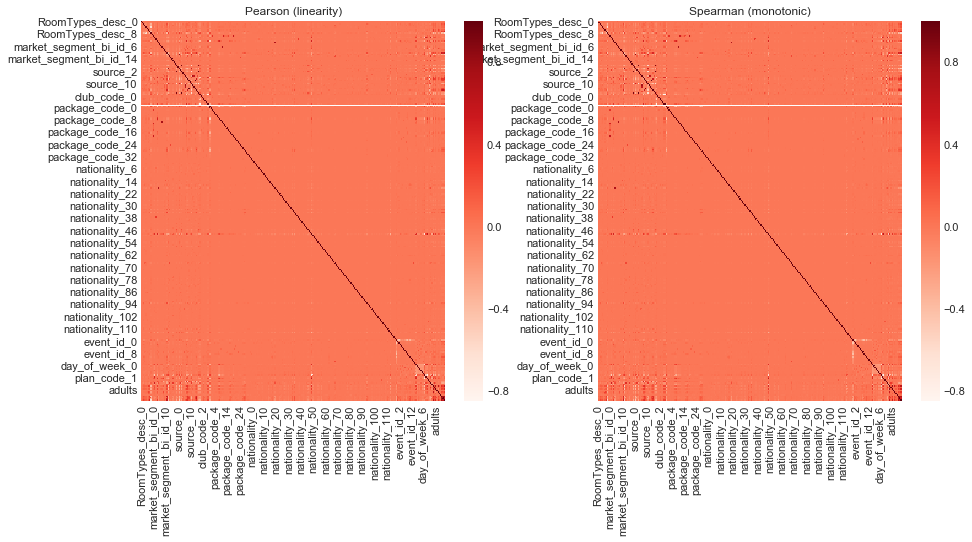

In [21]:
pearson_cor = encoded_df2.corr(method='pearson')
spearman_cor = encoded_df2.corr(method='spearman')

# Highlight relevant features
pearson_cor_targets = abs(pearson_cor[dependent_var])
spearman_cor_targets = abs(spearman_cor[dependent_var])
print('Relevant Features (Pearson):\n')
print(pearson_cor_targets[pearson_cor_targets > 0.2].sort_values(), '\n')
print('Relevant Features (Spearman):\n')
print(spearman_cor_targets[spearman_cor_targets > 0.2].sort_values())

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))
sns.heatmap(pearson_cor, ax=ax1, annot=False, cmap=plt.cm.Reds)
sns.heatmap(spearman_cor, ax=ax2, annot=False, cmap=plt.cm.Reds)
ax1.set_title('Pearson (linearity)')
ax2.set_title('Spearman (monotonic)')
plt.show()

In [22]:
%%script false --no-raise-error

plt.figure(figsize=(12,10))
ax = plt.axes()
sns.heatmap(pearson_cor, annot=True, cmap=plt.cm.Reds, ax=ax)
ax.set_title('Pearson (monotonic)')
plt.show()

plt.figure(figsize=(12,10))
ax = plt.axes()
sns.heatmap(spearman_cor, annot=True, cmap=plt.cm.Reds, ax=ax)
ax.set_title('Spearman (monotonic)')
plt.show()

<hr>

# Auxiliary Methods

In [23]:
def get_cv_scores(model, X_train, y_train):
    scores = cross_val_score(model,
                             X_train,
                             y_train,
                             cv=5,
                             scoring='r2')

    print('CV Mean Accuracy: ', np.mean(scores))
    print('CV STD Accuracy: ', np.std(scores), '\n')

In [24]:
def plot_model_results(model, X_train, X_test, y_train, y_test, y_pred):

    y_pred_train = model.predict(X_train)

    y_trn_smp = pd.DataFrame(y_train, index=X_train.index)
    y_trn_prd = pd.DataFrame(y_pred_train, index=X_train.index)
    y_tst_smp = pd.DataFrame(y_test, index=X_test.index)
    y_tst_prd = pd.DataFrame(y_pred, index=X_test.index)

    y_trn_smp_ma = y_trn_smp.groupby(y_trn_smp.index).mean().rolling(window=14).mean().fillna(0)
    y_trn_prd_ma = y_trn_prd.groupby(y_trn_prd.index).mean().rolling(window=14).mean().fillna(0)
    y_tst_smp_ma = y_tst_smp.groupby(y_tst_smp.index).mean().rolling(window=14).mean().fillna(0)
    y_tst_prd_ma = y_tst_prd.groupby(y_tst_prd.index).mean().rolling(window=14).mean().fillna(0)
    
    y_trn_ma = pd.concat([y_trn_smp_ma, y_trn_prd_ma], axis=1)
    y_trn_ma.columns = ['Sampled', 'Predicted']
    
    y_tst_ma = pd.concat([y_tst_smp_ma, y_tst_prd_ma], axis=1)
    y_tst_ma.columns = ['Sampled', 'Predicted']    
    
    # Figure 1:
    plt.figure(figsize=(20,12))
    
    plt.subplot(221)
    plt.scatter(y_train, y_pred_train)
    plt.plot(y_train, y_train, color='red', linewidth=1, linestyle='dashed')    
    plt.title('Train-Set')
    plt.xlabel('Sampled')
    plt.ylabel("Predicted")

    plt.subplot(222)
    plt.scatter(y_test, y_pred)
    plt.plot(y_test, y_test, color='red', linewidth=1, linestyle='dashed')    
    plt.title('Test-Set')
    plt.xlabel('Sampled')
    plt.ylabel("Predicted")

    plt.show()
    
    # Figure 2:
    fig, ax = plt.subplots(1, 2, figsize=(20,6))
    y_trn_ma.plot(ax=ax[0], linewidth=1)
    ax[0].xaxis_date()
    ax[0].set_title('Train-Set - Sampled vs. Predicted (MA=14)')
    ax[0].set_xlabel('Time')
    ax[0].legend()

    y_tst_ma.plot(ax=ax[1], linewidth=1)
    ax[1].xaxis_date()
    ax[1].set_title('Test-Set - Sampled vs. Predicted (MA=14)')
    ax[1].set_xlabel('Time')
    ax[1].legend()

    fig.autofmt_xdate()

    plt.show()

In [25]:
def plot_tree_features_importance(feature_importances, feature_labels, threshold):
    feature_import_val = feature_importances[feature_importances > threshold]
    feature_import_lbl = feature_labels[feature_importances > threshold]

    plt.figure(figsize=(12,6))
    plt.bar(feature_import_lbl, feature_import_val)
    plt.xticks(rotation='vertical')
    plt.title('Features Importance')
    plt.show()

In [26]:
def plot_permutation_importance(model, X, y, topN, n_repeats=10, random_state=42):
    result = permutation_importance(model, X, y, n_repeats=10, random_state=42)
    perm_sorted_idx = result.importances_mean.argsort()

    feature_import_val = result.importances[perm_sorted_idx].T[:,-topN:]
    feature_import_lbl = X.columns[perm_sorted_idx][-topN:]

    plt.figure(figsize=(12,6))
    plt.boxplot(feature_import_val, vert=False, labels=feature_import_lbl)
    plt.xticks(rotation='vertical')
    plt.title('Permutation Importance')
    plt.show()

In [27]:
def plot_partial_dependencies(model, X, target_features):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_title("Partial Dependencies")
    plot_partial_dependence(model, X, target_features, ax=ax, line_kw={"c": "red"})

In [28]:
def plot_partial_2d_dependencies(model, X, target_feature1, target_feature2):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_title("Partial Dependencies, 2D")
    plot_partial_dependence(model, 
                            X,
                            [(list(X.columns).index(target_feature1),
                              list(X.columns).index(target_feature2))],
                            n_jobs=3,
                            grid_resolution=20,
                            ax=ax)

In [29]:
def plot_learning_curve(history):

    fig, axes = plt.subplots(1, 1, figsize=(20,10))
    axes.plot(history['loss'], 'b', label='Train', linewidth=2)
    axes.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
    axes.set_title('Learning Curve', fontsize=20)
    axes.set_ylabel('Loss (mae)', fontsize=15)
    axes.set_xlabel('Epoch', fontsize=15)
    axes.legend(loc='upper right')
    plt.show()

In [30]:
def print_model_accuracy(model, X_train, y_train, X_test, y_test):
    score_trn = model.score(X_train, y_train) if abs(model.score(X_train, y_train))<=1 else 0
    score_tst = model.score(X_test, y_test) if abs(model.score(X_test, y_test))<=1 else 0
    print('Train Accuracy: ', score_trn)
    print('Test Accuracy: ', score_tst)

<hr>

# Basic Modelling

Linear Modelling:

![](https://miro.medium.com/max/1400/1*0W935wbGEcLZoqXIxkuhTQ.png)

### Normalization

In [31]:
scaler = MinMaxScaler if scaling_mode == "minmax" else StandardScaler()
encoded_scl_df = pd.DataFrame(scaler.fit_transform(encoded_df), 
                              index=encoded_df.index,
                              columns=encoded_df.columns)

encoded_scl_df.describe()

,RoomTypes_desc_0,RoomTypes_desc_1,RoomTypes_desc_2,RoomTypes_desc_3,RoomTypes_desc_4,RoomTypes_desc_5,RoomTypes_desc_6,RoomTypes_desc_7,RoomTypes_desc_8,RoomTypes_desc_9,...,m_length_of_stay,bed_nights,m_lead_days,adults,juniors,children,babies,capacity,ma14,ma100
count,8.388500e+04,8.388500e+04,8.388500e+04,8.388500e+04,8.388500e+04,8.388500e+04,8.388500e+04,8.388500e+04,8.388500e+04,8.388500e+04,...,8.388500e+04,8.388500e+04,8.388500e+04,8.388500e+04,8.388500e+04,8.388500e+04,8.388500e+04,8.388500e+04,8.388500e+04,8.388500e+04
mean,-8.364558e-19,8.131621e-18,-8.131621e-18,1.151980e-17,-3.388175e-17,1.423034e-17,1.423034e-17,-2.100669e-17,1.124874e-16,-4.976383e-19,...,3.523702e-17,-5.827662e-17,1.490797e-17,9.690182e-17,4.658741e-19,9.148074e-18,-2.032905e-17,-1.002900e-16,7.047405e-17,1.761851e-16
std,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,...,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00
min,-3.452713e-03,-4.985728e-02,-2.411196e-01,-2.074474e-01,-4.370627e-01,-3.277270e-02,-1.174809e-01,-2.760322e-01,-1.379164e+00,-3.452713e-03,...,-8.553917e-01,-7.608766e-01,-7.218746e-01,-2.438482e+00,-8.457636e-03,-3.021930e-01,-1.882759e-01,-3.445466e+00,-2.519119e+00,-3.118680e+00
25%,-3.452713e-03,-4.985728e-02,-2.411196e-01,-2.074474e-01,-4.370627e-01,-3.277270e-02,-1.174809e-01,-2.760322e-01,-1.379164e+00,-3.452713e-03,...,-6.541229e-01,-7.608766e-01,-6.119839e-01,-6.796810e-01,-8.457636e-03,-3.021930e-01,-1.882759e-01,-3.963760e-01,-7.282357e-01,-7.045890e-01
50%,-3.452713e-03,-4.985728e-02,-2.411196e-01,-2.074474e-01,-4.370627e-01,-3.277270e-02,-1.174809e-01,-2.760322e-01,7.250770e-01,-3.452713e-03,...,-2.515854e-01,-7.608766e-01,-4.105176e-01,-6.796810e-01,-8.457636e-03,-3.021930e-01,-1.882759e-01,4.315226e-01,-3.072176e-01,-2.591839e-01
75%,-3.452713e-03,-4.985728e-02,-2.411196e-01,-2.074474e-01,-4.370627e-01,-3.277270e-02,-1.174809e-01,-2.760322e-01,7.250770e-01,-3.452713e-03,...,3.522210e-01,6.332246e-01,1.023057e-01,1.079120e+00,-8.457636e-03,-3.021930e-01,-1.882759e-01,7.546050e-01,5.474942e-01,4.360082e-01
max,2.896273e+02,2.005725e+01,4.147320e+00,4.820499e+00,2.288001e+00,3.051320e+01,8.512019e+00,3.622766e+00,7.250770e-01,2.896273e+02,...,1.826514e+01,3.421427e+00,4.736031e+00,4.596721e+00,1.182363e+02,7.287465e+00,1.478662e+01,7.546050e-01,4.551150e+00,3.921257e+00


### Cross Validation (Train/Test split)

R-squared (R²), Mean Squared Error (MSE), Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE) are the most commonly used metrics to measure accuracy for continuous variables.<br>
The focus here is on R-Squared, aka the coefficient of determination, which implies how much variance in the target variable can be explained by the model.<br>
Values can range from 0 to 1. Higher values indicate a model that is highly predictive.<br>
For example, a R² value of 0.80 means that the model is accounting for 80% of the variability in the data.<br>
In general, the higher the R² value the better. However, a very high R² could be a sign of overfitting. <br>
Low values indicate that our model is not very good at predicting the target.<br>

<div><img src="https://miro.medium.com/max/2000/1*RZ7wWxTZxb6ySGGWJaY-CQ.jpeg" width=800"/></div>

Split the data into training and testing with a ratio of 80% and 20%

In [32]:
X_train, X_test, y_train, y_test = train_test_split(encoded_scl_df, 
                                                    dependent_series, 
                                                    test_size=cv_ratio, 
                                                    random_state=27,
                                                    shuffle=False)   # essential for TimeSeries

X_train = X_train.sort_index()
X_test = X_test.sort_index()
y_train = y_train.sort_index()
y_test = y_test.sort_index()

X_train.index = X_train.index.rename(index_var)
X_test.index = X_test.index.rename(index_var)
y_train.index = y_train.index.rename(index_var)
y_test.index = y_test.index.rename(index_var)

Prepare a combined Xy version as well

In [33]:
scaler_xy_train = MinMaxScaler if scaling_mode == "minmax" else StandardScaler()
scaler_xy_test = MinMaxScaler if scaling_mode == "minmax" else StandardScaler()

Xy_train = X_train.copy()
Xy_train[dependent_var] = y_train.values
Xy_train = pd.DataFrame(scaler_xy_train.fit_transform(Xy_train),
                        index=Xy_train.index,
                        columns=Xy_train.columns)

Xy_test = X_test.copy()
Xy_test[dependent_var] = y_test.values
Xy_test = pd.DataFrame(scaler_xy_test.fit_transform(Xy_test),
                       index=Xy_test.index,
                       columns=Xy_test.columns)

<hr>

### Linear Regressor

Linear regression finds the parameters to minimize the mean squared error or residuals between the predictions and the targets.<br>

<div><img src="https://gohantimes.com/wp-content/uploads/2019/11/ols-sum-of-square-diff.png" width="500"/></div>

Model: linear_regressor
CV Mean Accuracy:  -5.899745618209502e+25
CV STD Accuracy:  3.491073585336803e+25 

Train Accuracy:  0.8201230140376431
Test Accuracy:  0


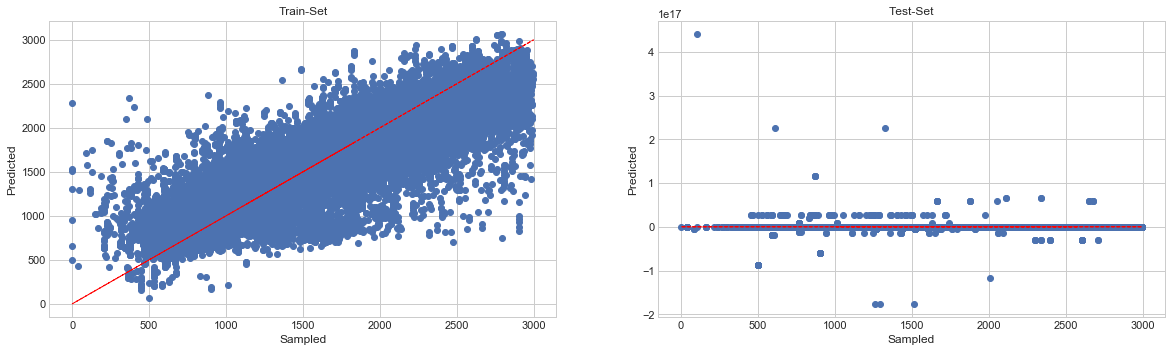

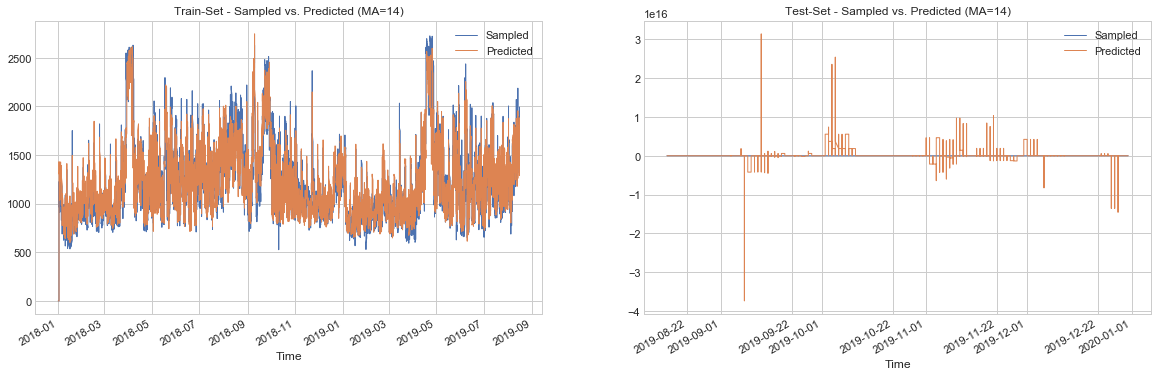

In [34]:
model_name = models[0]
print('Model: %s' % model_name)
model_file = save_path + "model_%s_h%d.pkl" % (model_name, hotel_sel)

if path.isfile(model_file) and not overwrite_saved_data:
    
    # Load an existing model
    model = joblib.load(model_file)

else:
    
    # Create object
    model = LinearRegression(n_jobs=4)

    # Train the model using the training sets
    model = model.fit(X_train, y_train)

    # Save the model
    joblib.dump(model, model_file) 

    # Get cross validation scores
    get_cv_scores(model, X_train, y_train)

print_model_accuracy(model, X_train, y_train, X_test, y_test)
    
# Make predictions using the testing set
y_pred = model.predict(X_test)

# Plot
plot_model_results(model, X_train, X_test, y_train, y_test, y_pred)

Examine the coefficients:

In [35]:
for coef, col in enumerate(X_train.columns[:10]):
    print('%s --> %.2f' % (col, model.coef_[coef]))

RoomTypes_desc_0 --> -376272450268.99
RoomTypes_desc_1 --> -5419978626577.60
RoomTypes_desc_2 --> -24833450912675.84
RoomTypes_desc_3 --> -21674869440105.50
RoomTypes_desc_4 --> -39991757909656.27
RoomTypes_desc_5 --> -3567739717194.79
RoomTypes_desc_6 --> -12628784114965.09
RoomTypes_desc_7 --> -27952228312545.68
RoomTypes_desc_8 --> -51790691579668.59
RoomTypes_desc_9 --> 1518539362833121.50


<hr>

### Ridge Regressor

Ridge regression uses L2 regularization to minimize the magnitude of the coefficients.<br>
It reduces the size of the coefficients and helps reduce model complexity.<br>
We control the complexity of our model with the regularization parameter, ⍺.<br>
Higher values of ⍺ force coefficients to move towards zero and increases the restriction on the model.<br>
This decreases training performance, but also increases the generalizability of the model. 

Model: ridge_regressor
CV Mean Accuracy:  0.7769509777683926
CV STD Accuracy:  0.01478018175427606 

Train Accuracy:  0.8205753384580251
Test Accuracy:  0.8252712824778345


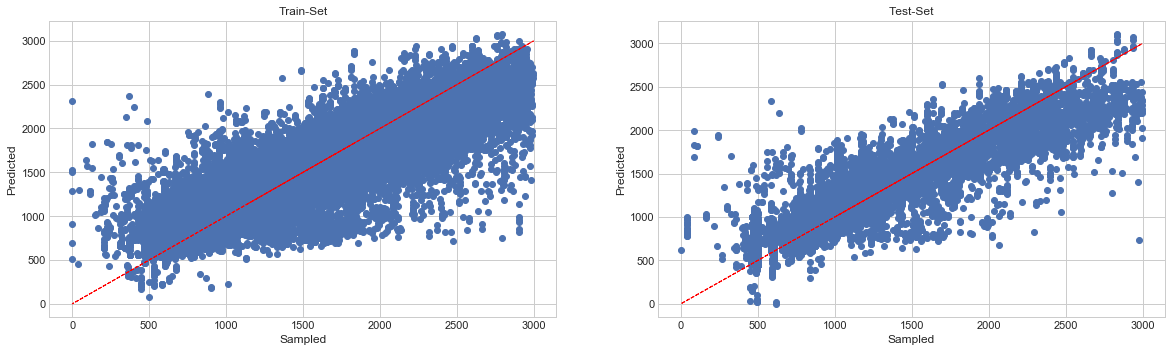

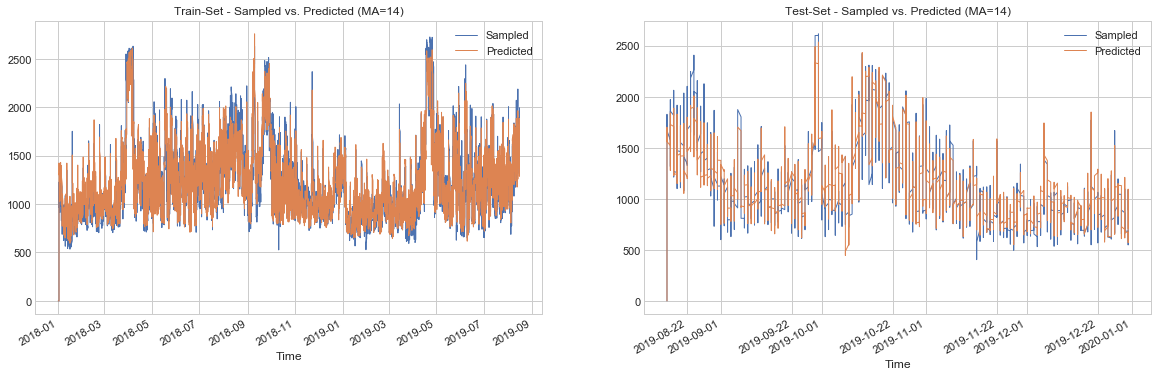

In [36]:
model_name = models[1]
print('Model: %s' % model_name)
model_file = save_path + "model_%s_h%d.pkl" % (model_name, hotel_sel)

if path.isfile(model_file) and not overwrite_saved_data:
    
    # Load an existing model
    model = joblib.load(model_file)

else:
    
    # Create object
    model = Ridge(alpha=0.1)

    # Hyper-Parameters optimization:
    if hyper_params_en:

        model = GridSearchCV(model,
                             {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
                             scoring='r2', 
                             verbose=1,
                             n_jobs=1).estimator

    # Train the model using the training sets
    model.fit(X_train, y_train)

    # Save the model
    joblib.dump(model, model_file)    
    
    # Get cross validation scores
    get_cv_scores(model, X_train, y_train)

print_model_accuracy(model, X_train, y_train, X_test, y_test)
    
# Make predictions using the testing set
y_pred = model.predict(X_test)

# Plot
plot_model_results(model, X_train, X_test, y_train, y_test, y_pred)

#### Plot Partial Dependencies (PDP)
Partial dependence plots (PDP) show the dependence between the target response and a set of ‘target’ features, marginalizing over the values of all other features (the ‘complement’ features). Intuitively, we can interpret the partial dependence as the expected target response as a function of the ‘target’ features.<br> X-axis represents the 'target feature', while y-axis represents the model prediction.<br>
[reference](https://www.kaggle.com/dansbecker/partial-dependence-plots)

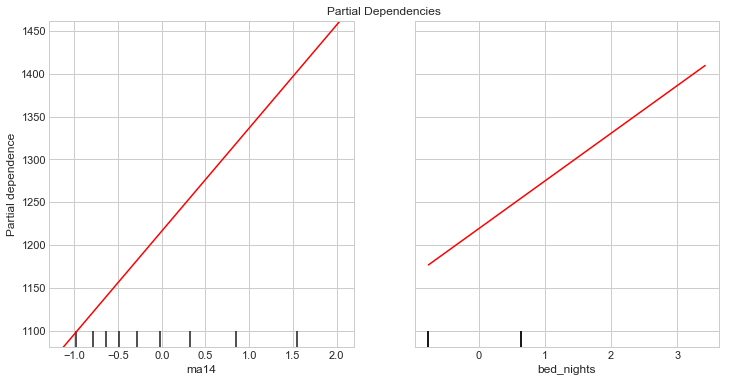

In [37]:
plot_partial_dependencies(model, X_train, ["ma14", "bed_nights"])

We can clearly see a linear relationship among these featrues.<br>
Note that PDPs assume that the target features are independent from the complement features, and this assumption is often violated in practice.

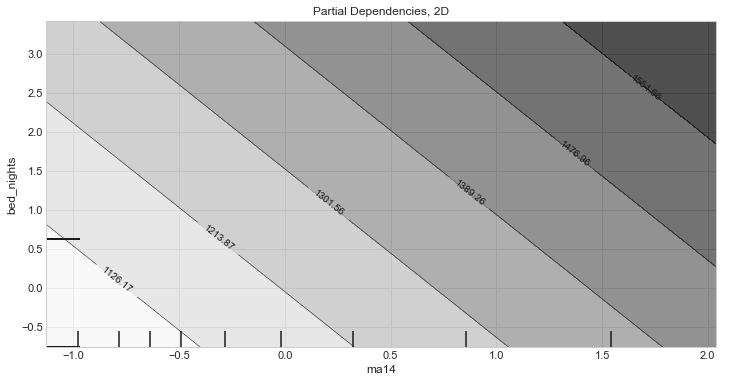

In [38]:
plot_partial_2d_dependencies(model, X_train, "ma14", "bed_nights")

#### Permutation Importance
“Permutation importance” is model-agnostic variable importance approach, so they do not require a single variable-related discrete training process like decision tree. The permutation feature importance is defined to be the decrease in a model score when a single feature value is randomly shuffled.<br>
[reference](https://scikit-learn.org/stable/modules/permutation_importance.html)

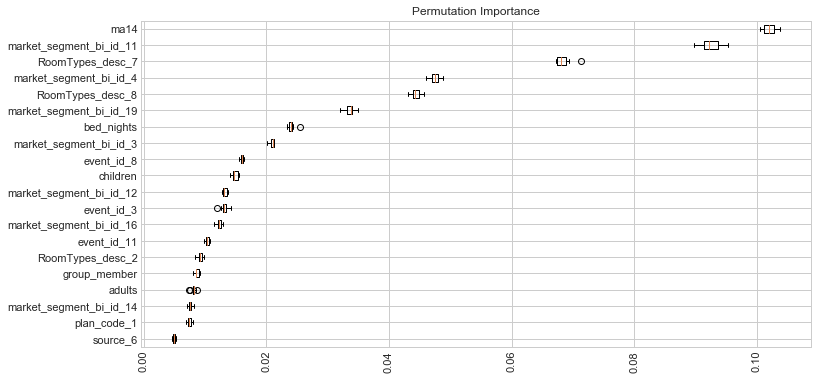

In [39]:
plot_permutation_importance(model, X_test, y_test, 20)

<hr>

### Lasso Regressor

Lasso regression uses L1 regularization to force some coefficients to be exactly zero.<br>
This means some features are completely ignored by the model. <br>
This can be thought of as a type of automatic feature selection!<br>
Lasso can be a good model choice when we have a large number of features but expect only a few to be important.<br>
Higher values of ⍺ force more coefficients to zero and can cause underfitting.<br>
Lower values of alpha lead to fewer non-zero features and can cause overfitting.<br>
Very low values of alpha will cause the model to resemble linear regression.

Model: lasso_regressor


/Users/shahargino/Library/Python/3.7/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2000491.9806246758, tolerance: 1717826.6795939794



CV Mean Accuracy:  0.7775947065666939
CV STD Accuracy:  0.014975517126648717 

Train Accuracy:  0.820557793516827
Test Accuracy:  0.816033481782894


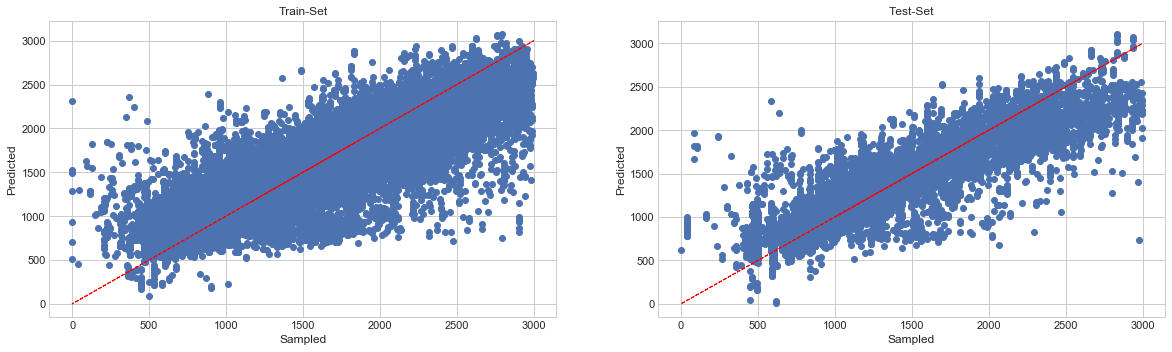

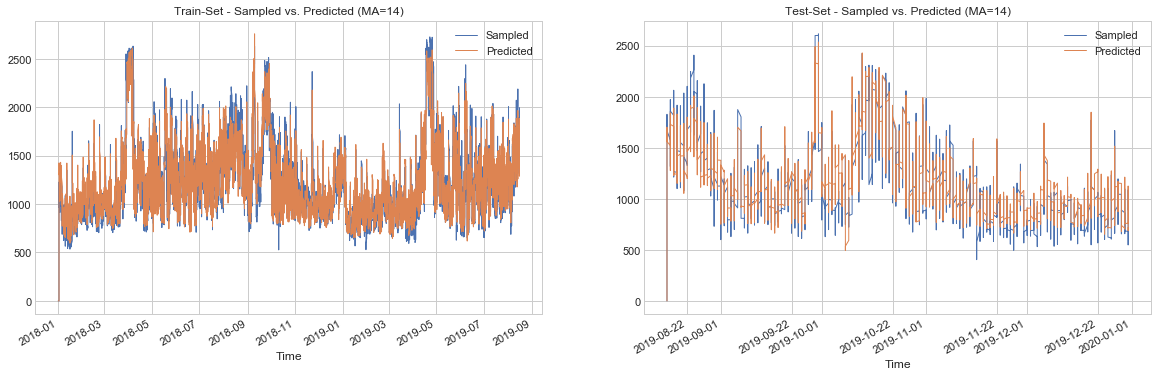

In [40]:
model_name = models[2]
print('Model: %s' % model_name)
model_file = save_path + "model_%s_h%d.pkl" % (model_name, hotel_sel)

if path.isfile(model_file) and not overwrite_saved_data:
    
    # Load an existing model
    model = joblib.load(model_file)

else:

    # Create object
    model = Lasso(alpha=0.1)

    # Hyper-Parameters optimization:
    if hyper_params_en:

        model = GridSearchCV(model,
                             {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
                             scoring='r2', 
                             verbose=1,
                             n_jobs=1).estimator

    # Train the model using the training sets
    model.fit(X_train, y_train)

    # Save the model
    joblib.dump(model, model_file)
    
    # Get cross validation scores
    get_cv_scores(model, X_train, y_train)

print_model_accuracy(model, X_train, y_train, X_test, y_test)
    
# Make predictions using the testing set
y_pred = model.predict(X_test)

# Plot
plot_model_results(model, X_train, X_test, y_train, y_test, y_pred)

<hr>

### Elastic-Net Regressor

Elastic-net is a linear regression model that combines the penalties of Lasso (L1) and Ridge (L2).<br>

<div><img src="https://miro.medium.com/max/1312/1*oECWmvwOKotaAA0czR30vg.png" width="500"/></div>

Model: elasticnet_regressor
CV Mean Accuracy:  0.7646012490160807
CV STD Accuracy:  0.019073412615086403 

Train Accuracy:  0.7998697499016268
Test Accuracy:  0.7673474436299209


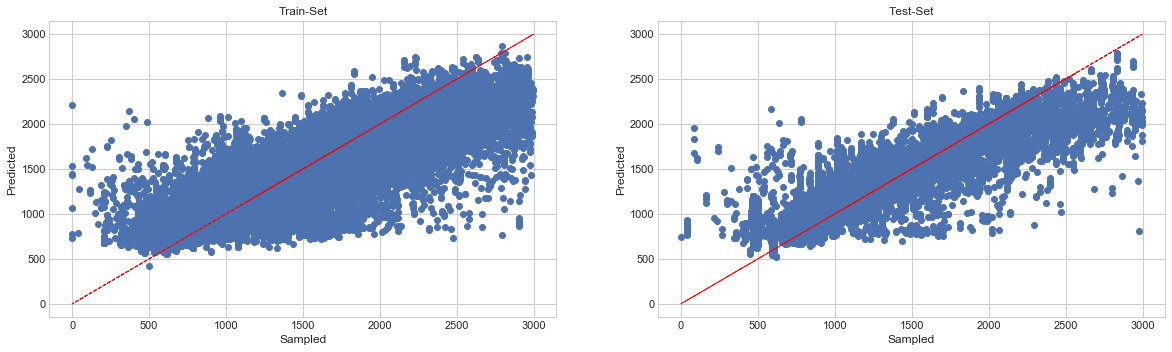

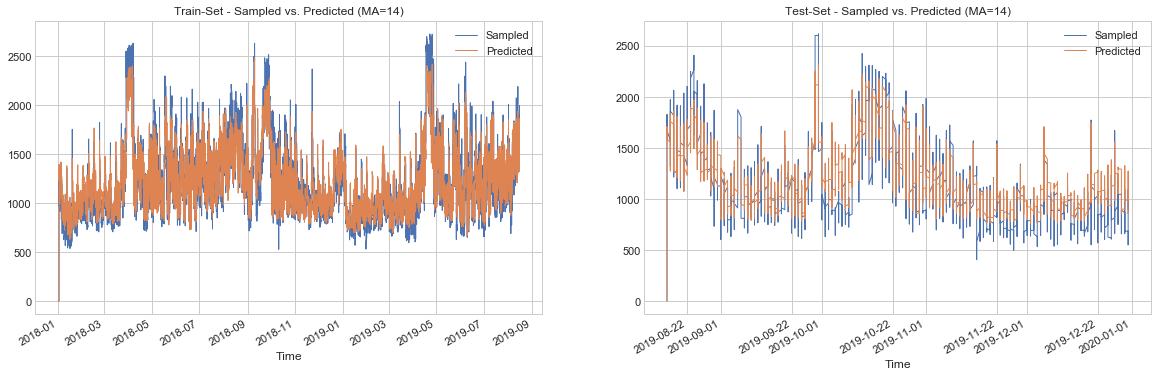

In [41]:
model_name = models[3]
print('Model: %s' % model_name)
model_file = save_path + "model_%s_h%d.pkl" % (model_name, hotel_sel)

if path.isfile(model_file) and not overwrite_saved_data:
    
    # Load an existing model
    model = joblib.load(model_file)

else:

    # Create object
    model = ElasticNet(alpha=1, l1_ratio=0.5)

    # Hyper-Parameters optimization:
    if hyper_params_en:

        model = GridSearchCV(model,
                             {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                              'l1_ratio': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}, 
                             scoring='r2', 
                             verbose=1,
                             n_jobs=1).estimator

    # Train the model using the training sets
    model.fit(X_train, y_train)
    
    # Save the model
    joblib.dump(model, model_file)

    # Get cross validation scores
    get_cv_scores(model, X_train, y_train)

print_model_accuracy(model, X_train, y_train, X_test, y_test)

# Make predictions using the testing set
y_pred = model.predict(X_test)

# Plot
plot_model_results(model, X_train, X_test, y_train, y_test, y_pred)

### Support Vector Regressor

The method of Support Vector Classification can be extended to solve regression problems, termed as Support Vector Regression.<br>
The model produced by support vector classification (classic SVM) depends only on a subset of the training data, because the cost function for building the model does not care about training points that lie beyond the margin.<br>
Analogously, the model produced by Support Vector Regression depends only on a subset of the training data, because the cost function for building the model ignores any training data close to the model prediction.<br>
In simple regression we try to minimise the error rate. While in SVR we try to fit the error within a certain threshold<br>

<div><img src="https://miro.medium.com/max/1400/1*rs0EfF8RPVpgA-EfgAq85g.jpeg" width="500"/></div>

Model: supportvect_regressor


/Users/shahargino/Library/Python/3.7/lib/python/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/Users/shahargino/Library/Python/3.7/lib/python/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/Users/shahargino/Library/Python/3.7/lib/python/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/Users/shahargino/Library/Python/3.7/lib/python/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/Users/shahargino/Library/Python/3.7/lib/python/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/Users/shahargino/Library/Python/3.7/lib/python/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning:

Liblinear failed

CV Mean Accuracy:  0.5712937390552668
CV STD Accuracy:  0.31308417249417947 

Train Accuracy:  0.8135738561008121
Test Accuracy:  0.7074132989738298


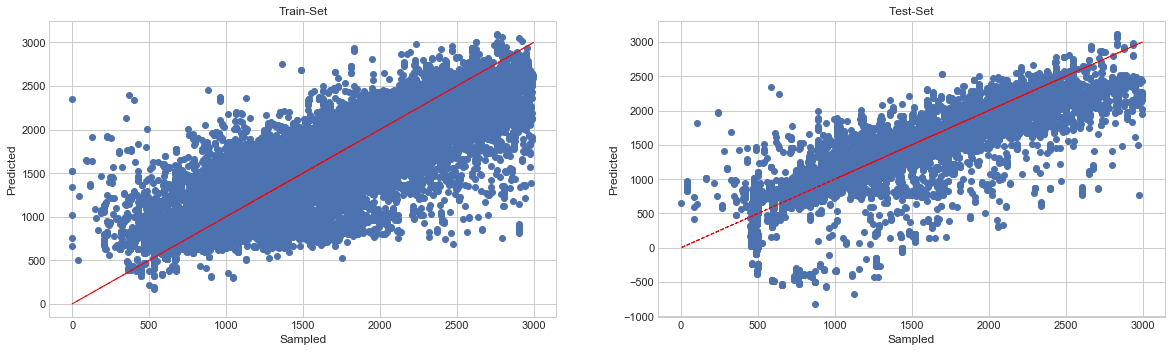

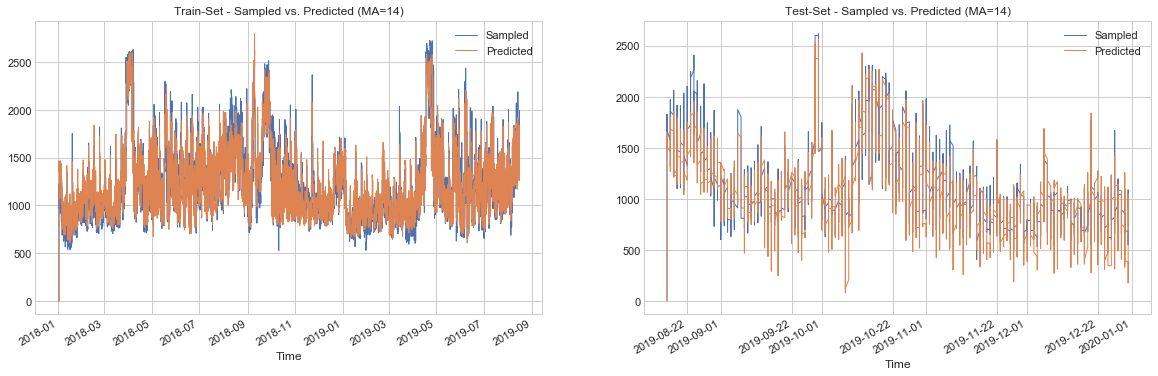

In [42]:
model_name = models[4]
print('Model: %s' % model_name)
model_file = save_path + "model_%s_h%d.pkl" % (model_name, hotel_sel)

if path.isfile(model_file) and not overwrite_saved_data:
    
    # Load an existing model
    model = joblib.load(model_file)

else:

    # Create object
    model = LinearSVR(random_state=0, tol=1e-5)

    # Train the model using the training sets
    model = model.fit(X_train, y_train)

    # Save the model
    joblib.dump(model, model_file) 
    
    # Get cross validation scores
    get_cv_scores(model, X_train, y_train)

print_model_accuracy(model, X_train, y_train, X_test, y_test)

# Make predictions using the testing set
y_pred = model.predict(X_test)

# Plot
plot_model_results(model, X_train, X_test, y_train, y_test, y_pred)

<hr>

# Trees

### Decision Tree Regressor

<div><img src="https://miro.medium.com/max/1630/1*XZ220vTa7rN8ccJZZNe09w.png" width="500"/></div>

Model: decisiontree_regressor
CV Mean Accuracy:  0.6011786552930076
CV STD Accuracy:  0.014217863851127664 

Train Accuracy:  0.999905008601096
Test Accuracy:  0.5722826698793689


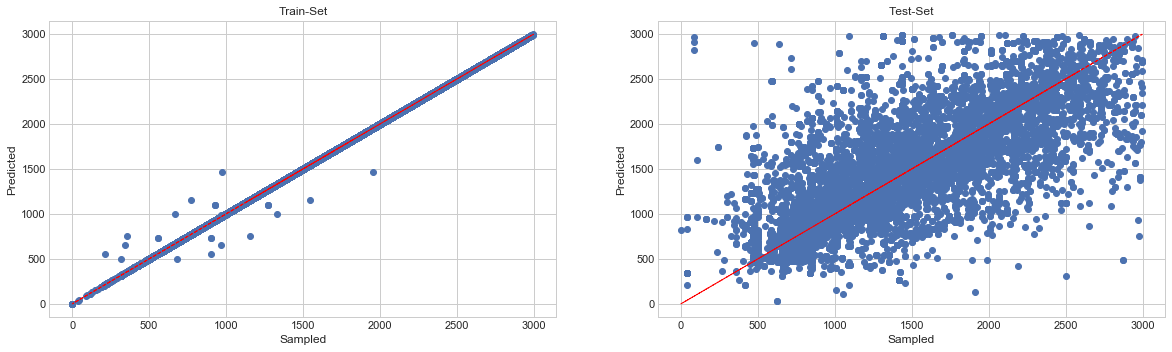

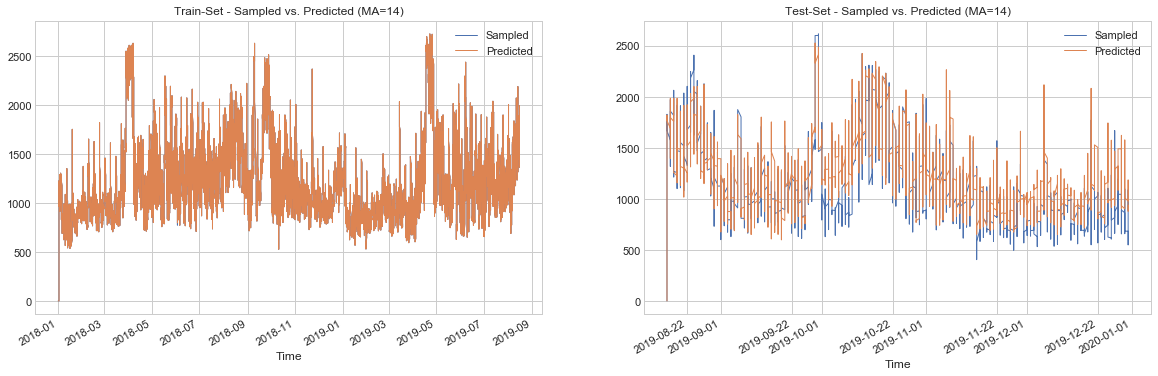

In [43]:
model_name = models[5]
print('Model: %s' % model_name)
model_file = save_path + "model_%s_h%d.pkl" % (model_name, hotel_sel)

if path.isfile(model_file) and not overwrite_saved_data:
    
    # Load an existing model
    model = joblib.load(model_file)

else:

    # Create object
    model = DecisionTreeRegressor(random_state=0)

    # Train the model using the training sets
    model.fit(X_train, y_train)

    # Save the model
    joblib.dump(model, model_file)
    
    # Get cross validation scores
    get_cv_scores(model, X_train, y_train)

print_model_accuracy(model, X_train, y_train, X_test, y_test)
    
# Make predictions using the testing set
y_pred = model.predict(X_test)

# Plot
plot_model_results(model, X_train, X_test, y_train, y_test, y_pred)

Feature Importances

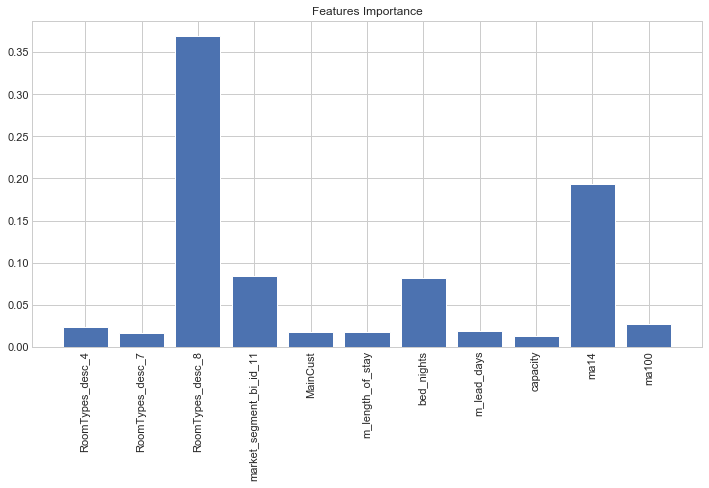

In [44]:
plot_tree_features_importance(model.feature_importances_, X_train.columns, 0.01)

Tree Visualization

In [45]:
%%script false --no-raise-error

plot_tree(model)

<hr>

### Random Forest Regressor

A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting<br>

<div><img src="https://databricks.com/wp-content/uploads/2015/01/Ensemble-example.png" width="500"/></div>

Model: randomforest_regressor
CV Mean Accuracy:  0.5771633521884763
CV STD Accuracy:  0.0728386649468965 

Train Accuracy:  0.6271630357090521
Test Accuracy:  0.575847700508494


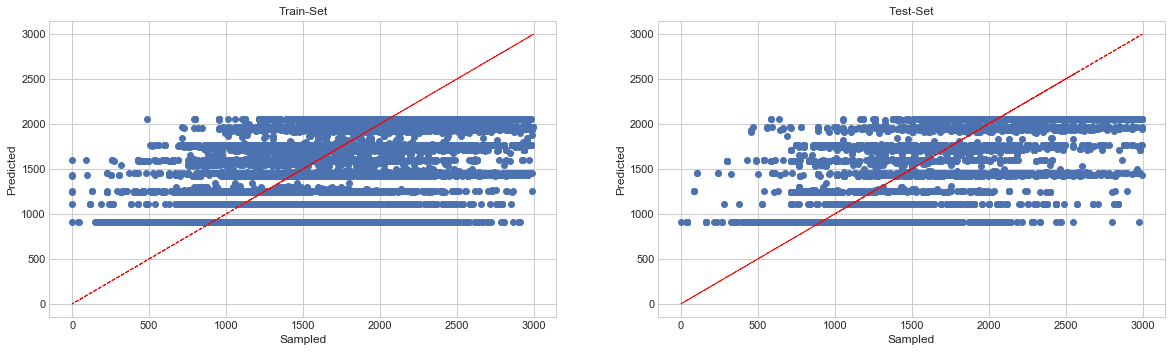

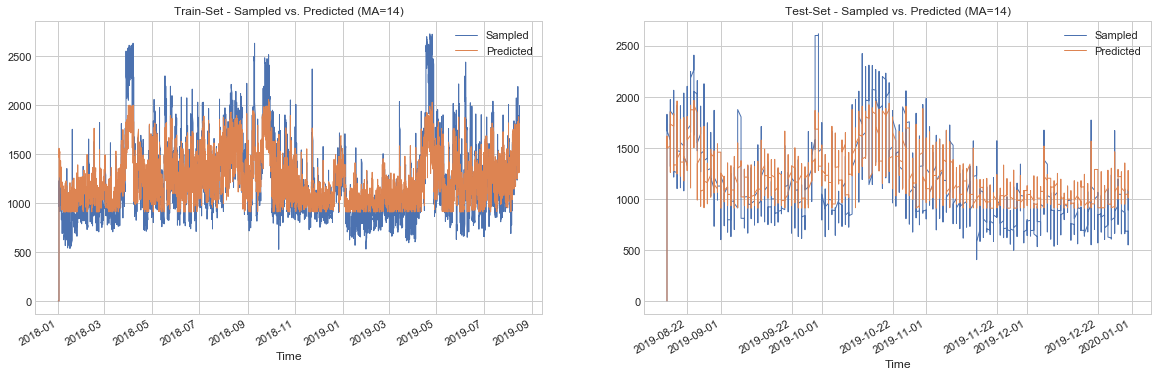

In [46]:
model_name = models[6]
print('Model: %s' % model_name)
model_file = save_path + "model_%s_h%d.pkl" % (model_name, hotel_sel)

if path.isfile(model_file) and not overwrite_saved_data:
    
    # Load an existing model
    model = joblib.load(model_file)

else:

    # Create object
    model = RandomForestRegressor(max_depth=2, random_state=0)

    # Train the model using the training sets
    model.fit(X_train, y_train)

    # Save the model
    joblib.dump(model, model_file)
    
    # Get cross validation scores
    get_cv_scores(model, X_train, y_train)

print_model_accuracy(model, X_train, y_train, X_test, y_test)
    
# Make predictions using the testing set
y_pred = model.predict(X_test)

# Plot
plot_model_results(model, X_train, X_test, y_train, y_test, y_pred)

Feature Importances

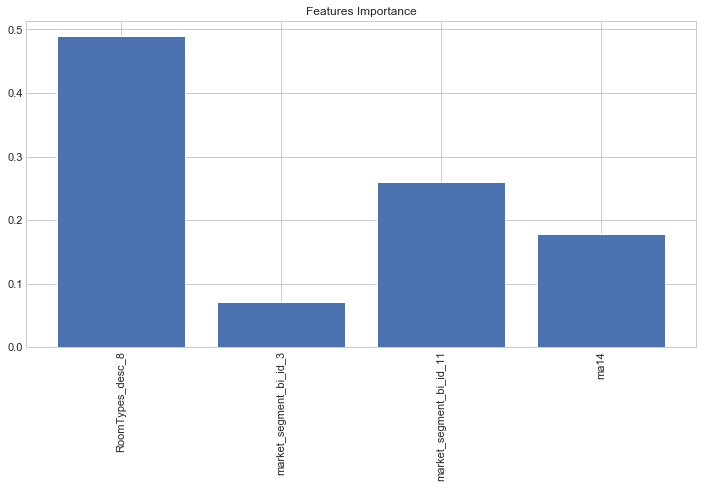

In [47]:
plot_tree_features_importance(model.feature_importances_, X_train.columns, 0.01)

<hr>

### XGBoost Regressor

XGBoost stands for “Extreme Gradient Boosting”, where the term “Gradient Boosting” originates from the paper Greedy Function Approximation: A Gradient Boosting Machine, by Friedman.<br>

<div><img src="https://miro.medium.com/max/1000/0*tzKt_ABz5rRrsGoW.jpg" width="500"/></div>

Model: xgboost_regressor
CV Mean Accuracy:  0.8064706515913838
CV STD Accuracy:  0.017164757375768377 

Train Accuracy:  0.8527805508247579
Test Accuracy:  0.8129464434079005


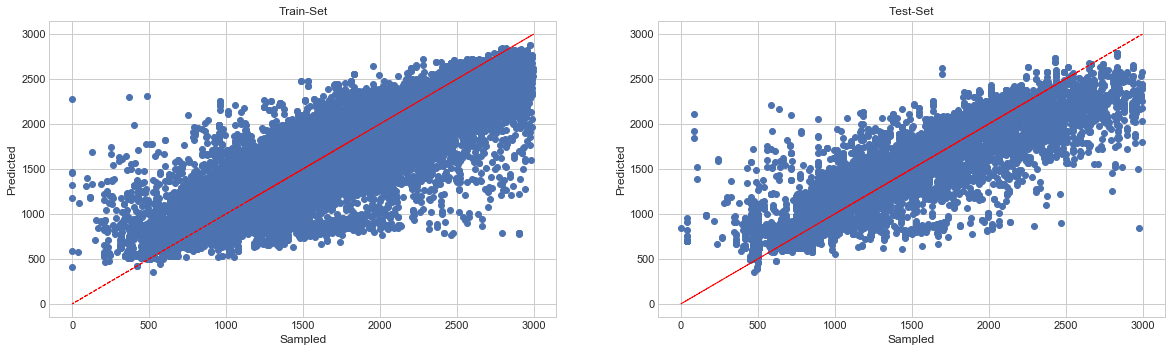

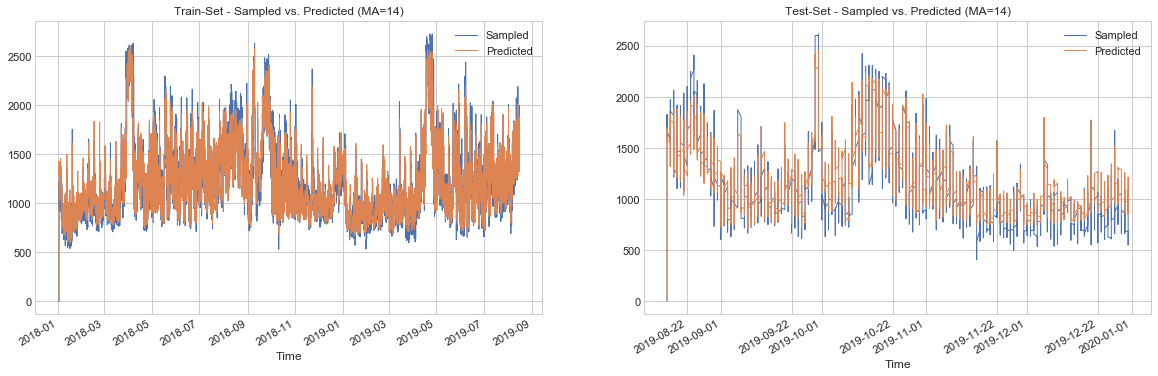

Base Score:  0.5


In [48]:
model_name = models[7]
print('Model: %s' % model_name)
model_file = save_path + "model_%s_h%d.pkl" % (model_name, hotel_sel)

if path.isfile(model_file) and not overwrite_saved_data:
    
    # Load an existing model
    model = joblib.load(model_file)

else:
    
    # Create object
    model = xgb.XGBRegressor(objective='reg:squarederror', max_depth=4, n_estimators=100)

    # Hyper-Parameters optimization:
    if hyper_params_en:

        model = GridSearchCV(model,
                             {'max_depth': [2,4,6],
                              'n_estimators': [50,100,200]}, 
                             verbose=1,
                             n_jobs=1).estimator

    # Train the model using the training sets
    model.fit(X_train, y_train)
    
    # Save the model
    joblib.dump(model, model_file)

    # Get cross validation scores
    get_cv_scores(model, X_train, y_train)
    
print_model_accuracy(model, X_train, y_train, X_test, y_test)
    
# Make predictions using the testing set
y_pred = model.predict(X_test)

# Plot
plot_model_results(model, X_train, X_test, y_train, y_test, y_pred)

print('Base Score: ', model.base_score)

Feature Importances

Text(0.5, 1.0, 'Features Importance')

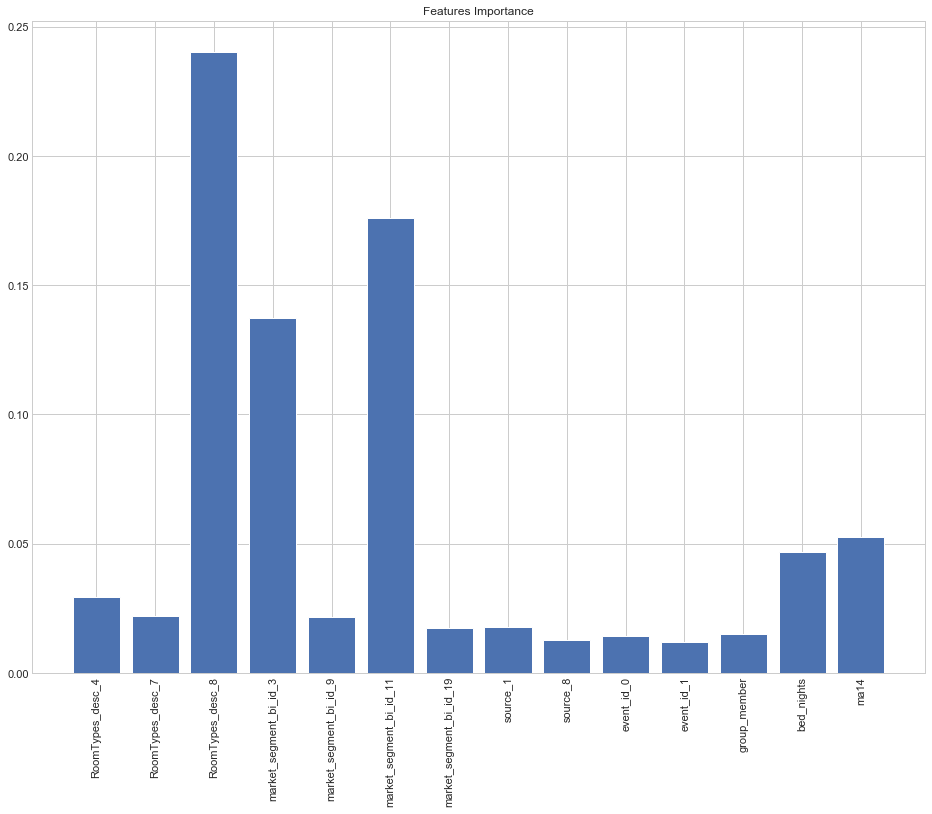

In [49]:
feature_import_thr = 0.01
feature_import_val = model.feature_importances_[model.feature_importances_ > feature_import_thr]
feature_import_lbl = X_train.columns[model.feature_importances_ > feature_import_thr]

plt.figure(figsize=(16,12))
plt.bar(feature_import_lbl, feature_import_val)
plt.xticks(rotation='vertical')
plt.title('Features Importance')

__Partial Dependency Plot (PDP)__ - create a dependence plot to show the effect of a single feature across the whole dataset ([reference](https://shap.readthedocs.io/en/latest/))

A dependence plot is a scatter plot that shows the effect a single feature has on the predictions made by the model.

- Each dot is a single prediction (row) from the dataset.
- The x-axis is the value of the feature on-focus
- The y-axis is the SHAP value for that feature, represents how much knowing that feature's value changes model's output for that sample's prediction
- The color corresponds to a second feature that may have an interaction effect with the feature we are plotting (chosen automatically by default). If an interaction effect is present between this other feature and the feature we are plotting it will show up as a distinct vertical pattern of coloring.

/Users/shahargino/Library/Python/3.7/lib/python/site-packages/shap/explainers/tree.py:114: UserWarning:

Setting feature_perturbation = "tree_path_dependent" because no background data was given.



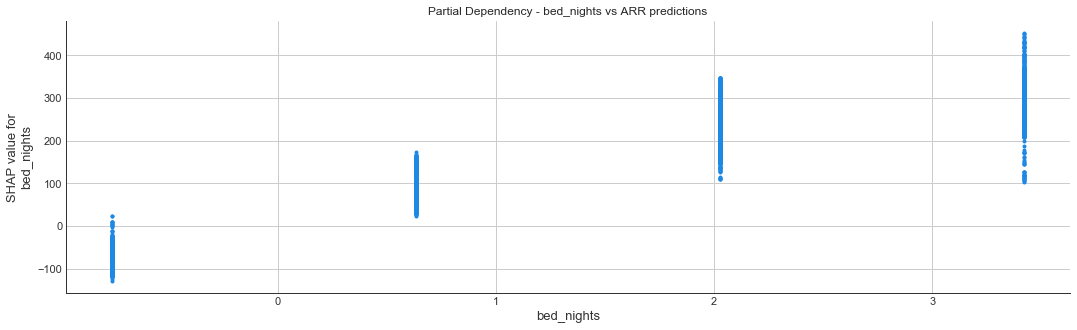

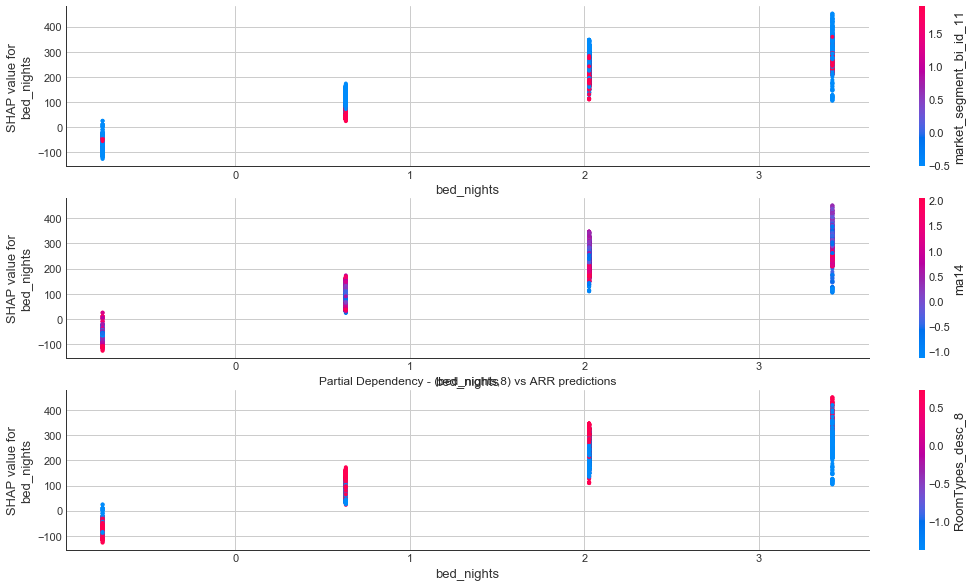

In [50]:
feature_id = 'bed_nights'

# Create object that can calculate shap values (SHapley Additive exPlanations)
explainer = shap.TreeExplainer(model)

# Calculate shap values. This is what we will plot.
shap_values = explainer.shap_values(X_train)

# Turn off interaction coloring:
fig, ax = plt.subplots(1, 1, figsize=(18,5))
shap.dependence_plot(feature_id, shap_values, X_train, interaction_index=None, ax=ax, show=False)
plt.title('Partial Dependency - %s vs %s predictions' % (feature_id, dependent_var))
plt.show()

# Make plots colored by each of the top three possible interacting features
inds = shap.approximate_interactions(feature_id, shap_values, X_train)
fig, ax = plt.subplots(3, 1, figsize=(18,10))
for i in range(3):
    shap.dependence_plot(feature_id, shap_values, X_train, interaction_index=inds[i], ax=ax[i], show=False)
plt.title('Partial Dependency - (%s,%s) vs %s predictions' % (feature_id, inds[i], dependent_var))
plt.show()    

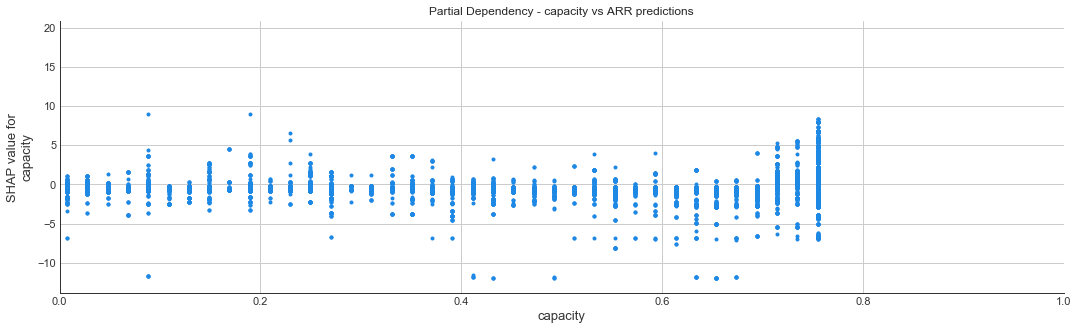

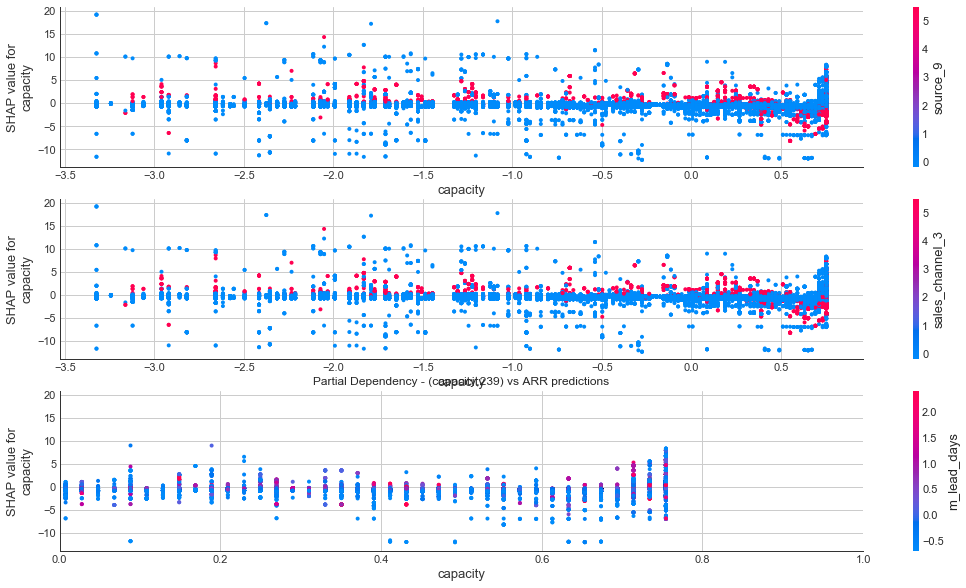

In [51]:
feature_id = 'capacity'

# Create object that can calculate shap values (SHapley Additive exPlanations)
explainer = shap.TreeExplainer(model)

# Calculate shap values. This is what we will plot.
shap_values = explainer.shap_values(X_train)

# Turn off interaction coloring:
fig, ax = plt.subplots(1, 1, figsize=(18,5))
shap.dependence_plot(feature_id, shap_values, X_train, interaction_index=None, ax=ax, show=False)
plt.xlim([0,1])
plt.title('Partial Dependency - %s vs %s predictions' % (feature_id, dependent_var))
plt.show()

# Make plots colored by each of the top three possible interacting features
inds = shap.approximate_interactions(feature_id, shap_values, X_train)
fig, ax = plt.subplots(3, 1, figsize=(18,10))
for i in range(3):
    shap.dependence_plot(feature_id, shap_values, X_train, interaction_index=inds[i], ax=ax[i], show=False)
plt.xlim([0,1])
plt.title('Partial Dependency - (%s,%s) vs %s predictions' % (feature_id, inds[i], dependent_var))
plt.show()    

<hr>

# Neural Networks

### Multi-layer Perceptron

A Multi-layer Perceptron (MLP) Regression System is a multilayer feedforward neural network training system that implements multi-layer perceptron regression algorithm to solve a Multi-layer Perceptron Regression Task.<br>

<div><img src="https://miro.medium.com/max/1400/1*-IPQlOd46dlsutIbUq1Zcw.png" width="500"/></div>

Model: mlp_regressor


/Users/shahargino/Library/Python/3.7/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

/Users/shahargino/Library/Python/3.7/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

/Users/shahargino/Library/Python/3.7/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.



CV Mean Accuracy:  -2.4154161818452082e+34
CV STD Accuracy:  3.33605193272289e+34 

Train Accuracy:  0.9444686561345287
Test Accuracy:  0


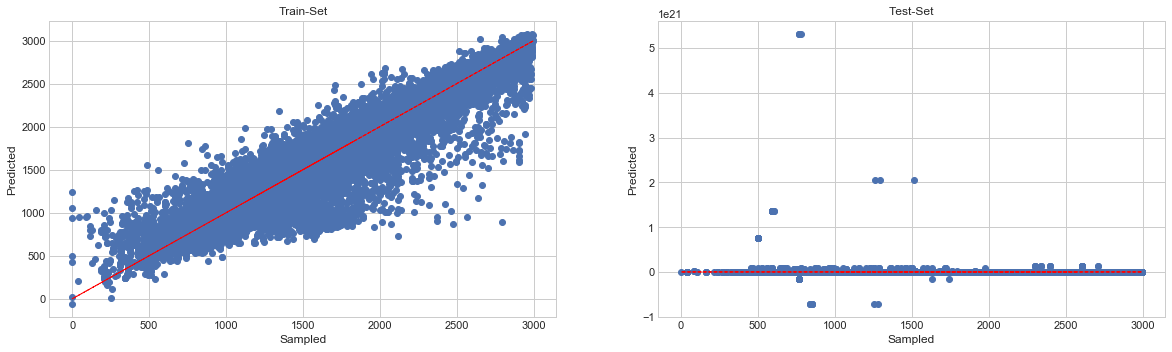

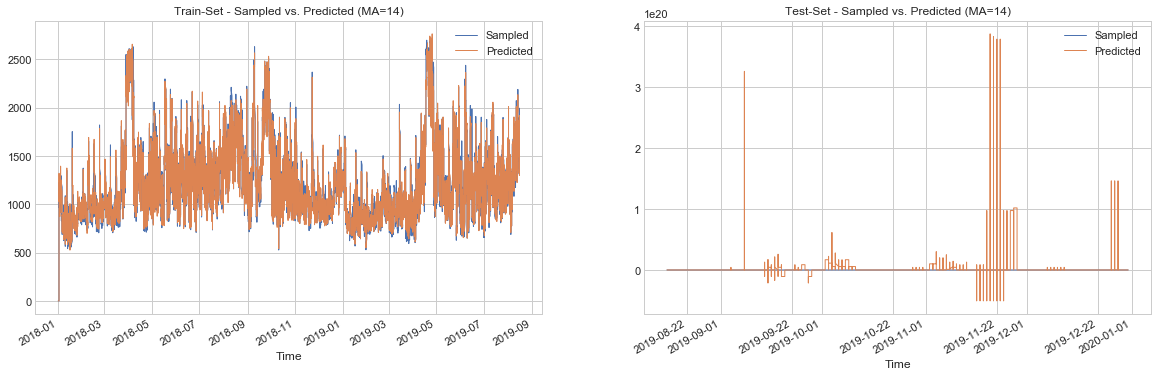

In [52]:
model_name = models[8]
print('Model: %s' % model_name)
model_file = save_path + "model_%s_h%d.pkl" % (model_name, hotel_sel)

if path.isfile(model_file) and not overwrite_saved_data:
    
    # Load an existing model
    model = joblib.load(model_file)

else:
    
    # Create object
    model = make_pipeline(StandardScaler(),
                          MLPRegressor(hidden_layer_sizes=(100, 100),
                                       tol=1e-2, 
                                       max_iter=500,
                                       random_state=0))

    # Train the model using the training sets
    model.fit(X_train, y_train)
    
    # Save the model
    joblib.dump(model, model_file)

    # Get cross validation scores
    get_cv_scores(model, X_train, y_train)

print_model_accuracy(model, X_train, y_train, X_test, y_test)
    
# Make predictions using the testing set
y_pred = model.predict(X_test)

# Plot
plot_model_results(model, X_train, X_test, y_train, y_test, y_pred)

<hr>

### LSTM RNN (Tensorflow)

Recurrent Neural Networks (RNN) have been proven to efficiently solve sequence problems. Particularly, Long Short Term Memory Network (LSTM), which is a variation of RNN, is currently being used in a variety of domains to solve sequence problems.<br>
<br>
<div><img src="https://i.stack.imgur.com/Mpzfy.jpg" width="500"/></div>

In [53]:
def lstm_calculate_loss(model, dataset, dataset_idx, X_true, plot_en=True):

    # Predict:
    Xpred = model.predict(dataset)
    Xpred = pd.DataFrame(Xpred, index=dataset_idx, columns=[dependent_var])

    # Ground Truth:
    Xtrue = X_true.copy()
    Xtrue = pd.DataFrame(Xtrue, index=dataset_idx, columns=[dependent_var])

    # Loss calculation:
    loss_mae = pd.DataFrame(index=dataset_idx)
    loss_mae = np.mean(np.abs(Xpred-Xtrue), axis=1)

    # R2 score
    r2 = r2_score(Xtrue[dependent_var], Xpred[dependent_var])
    
    # Plot:
    if plot_en:
        fig, axes = plt.subplots(2, 1, figsize=(30,15))
        sns.distplot(loss_mae, bins=20, kde=True, color='blue', ax=axes[0])
        axes[0].set_title('Loss Distribution', fontsize=20)
        axes[0].set_xlabel('Loss Distribution', fontsize=15)
        #axes[0].set_xlim([0.0,.5])
        axes[1].set_title('Sampled vs. Predicted', fontsize=20)
        axes[1].set_xlabel('Time', fontsize=15)
        Xtrue[dependent_var].plot(subplots=True, ax=axes[1], color='Blue', label='Sampeld')
        Xpred[dependent_var].plot(subplots=True, ax=axes[1], color='Green', label='Predicted')
        axes[1].legend()
        plt.show()
        
    return loss_mae, Xtrue, Xpred, r2

Model: lstm_rnn
Train on 63752 samples, validate on 3356 samples
Epoch 1/1000
63752/63752 - 2s - loss: 1793359.8742 - val_loss: 1986449.8296
Epoch 2/1000
63752/63752 - 1s - loss: 1759528.1508 - val_loss: 1949312.7011
Epoch 3/1000
63752/63752 - 1s - loss: 1724017.6106 - val_loss: 1909502.3340
Epoch 4/1000
63752/63752 - 1s - loss: 1682515.7035 - val_loss: 1865041.9072
Epoch 5/1000
63752/63752 - 1s - loss: 1649206.2466 - val_loss: 1831755.5404
Epoch 6/1000
63752/63752 - 1s - loss: 1620296.1778 - val_loss: 1801437.1372
Epoch 7/1000
63752/63752 - 1s - loss: 1592922.6891 - val_loss: 1772259.9909
Epoch 8/1000
63752/63752 - 1s - loss: 1566193.0075 - val_loss: 1743618.9005
Epoch 9/1000
63752/63752 - 1s - loss: 1539896.0446 - val_loss: 1714809.6733
Epoch 10/1000
63752/63752 - 1s - loss: 1512267.9986 - val_loss: 1684865.0687
Epoch 11/1000
63752/63752 - 1s - loss: 1483090.8535 - val_loss: 1653491.8097
Epoch 12/1000
63752/63752 - 1s - loss: 1453893.9616 - val_loss: 1623763.2509
Epoch 13/1000
63752/

Epoch 109/1000
63752/63752 - 1s - loss: 302624.4307 - val_loss: 306216.5247
Epoch 110/1000
63752/63752 - 1s - loss: 297757.8043 - val_loss: 300226.3039
Epoch 111/1000
63752/63752 - 1s - loss: 293518.4671 - val_loss: 294430.0315
Epoch 112/1000
63752/63752 - 1s - loss: 288014.7419 - val_loss: 288745.5381
Epoch 113/1000
63752/63752 - 1s - loss: 284102.2184 - val_loss: 283027.8002
Epoch 114/1000
63752/63752 - 1s - loss: 279758.7899 - val_loss: 277442.7744
Epoch 115/1000
63752/63752 - 1s - loss: 275092.9359 - val_loss: 272093.2259
Epoch 116/1000
63752/63752 - 1s - loss: 271018.7714 - val_loss: 266750.9555
Epoch 117/1000
63752/63752 - 1s - loss: 267040.0780 - val_loss: 261468.9879
Epoch 118/1000
63752/63752 - 1s - loss: 262357.1314 - val_loss: 256133.7712
Epoch 119/1000
63752/63752 - 1s - loss: 258868.5293 - val_loss: 250900.9444
Epoch 120/1000
63752/63752 - 1s - loss: 254732.0710 - val_loss: 246059.3278
Epoch 121/1000
63752/63752 - 1s - loss: 250426.7140 - val_loss: 241347.9043
Epoch 122/10

63752/63752 - 1s - loss: 90925.3175 - val_loss: 110029.9922
Epoch 218/1000
63752/63752 - 1s - loss: 90471.7233 - val_loss: 109085.8563
Epoch 219/1000
63752/63752 - 1s - loss: 90346.5278 - val_loss: 109722.5842
Epoch 220/1000
63752/63752 - 1s - loss: 88530.4361 - val_loss: 109224.9595
Epoch 221/1000
63752/63752 - 1s - loss: 89294.2280 - val_loss: 109245.1051
Epoch 222/1000
63752/63752 - 1s - loss: 89413.0199 - val_loss: 109085.4879
Epoch 223/1000
63752/63752 - 1s - loss: 88506.3274 - val_loss: 108434.2923
Epoch 224/1000
63752/63752 - 1s - loss: 88309.1359 - val_loss: 108940.7874
Epoch 225/1000
63752/63752 - 1s - loss: 87092.2883 - val_loss: 109119.5739
Epoch 226/1000
63752/63752 - 1s - loss: 87192.9473 - val_loss: 109870.7101
Epoch 227/1000
63752/63752 - 1s - loss: 86385.3335 - val_loss: 109688.6795
Epoch 228/1000
63752/63752 - 1s - loss: 87053.0037 - val_loss: 109433.5205
Epoch 229/1000
63752/63752 - 1s - loss: 86174.9918 - val_loss: 110297.1825
Epoch 230/1000
63752/63752 - 1s - loss: 

Epoch 327/1000
63752/63752 - 1s - loss: 71477.0384 - val_loss: 118413.5279
Epoch 328/1000
63752/63752 - 1s - loss: 70406.1763 - val_loss: 115837.6135
Epoch 329/1000
63752/63752 - 1s - loss: 70077.4314 - val_loss: 115323.3384
Epoch 330/1000
63752/63752 - 1s - loss: 69183.3713 - val_loss: 116476.1725
Epoch 331/1000
63752/63752 - 1s - loss: 70400.9849 - val_loss: 117636.5116
Epoch 332/1000
63752/63752 - 1s - loss: 70479.6008 - val_loss: 118177.5736
Epoch 333/1000
63752/63752 - 1s - loss: 71303.9368 - val_loss: 119264.0156
Epoch 334/1000
63752/63752 - 1s - loss: 69775.7220 - val_loss: 117257.7555
Epoch 335/1000
63752/63752 - 1s - loss: 68970.6030 - val_loss: 116906.6389
Epoch 336/1000
63752/63752 - 1s - loss: 69509.4721 - val_loss: 117803.7687
Epoch 337/1000
63752/63752 - 1s - loss: 68874.7832 - val_loss: 117163.9195
Epoch 338/1000
63752/63752 - 1s - loss: 69717.9598 - val_loss: 117869.1357
Epoch 339/1000
63752/63752 - 1s - loss: 68732.0080 - val_loss: 117219.1961
Epoch 340/1000
63752/6375

Epoch 437/1000
63752/63752 - 1s - loss: 63460.0869 - val_loss: 118075.7486
Epoch 438/1000
63752/63752 - 1s - loss: 65326.4595 - val_loss: 117694.3911
Epoch 439/1000
63752/63752 - 1s - loss: 64016.8544 - val_loss: 117179.0287
Epoch 440/1000
63752/63752 - 1s - loss: 63907.9229 - val_loss: 116999.9366
Epoch 441/1000
63752/63752 - 1s - loss: 63484.5641 - val_loss: 117453.6839
Epoch 442/1000
63752/63752 - 1s - loss: 63841.4515 - val_loss: 115957.3060
Epoch 443/1000
63752/63752 - 2s - loss: 63751.7392 - val_loss: 115607.5163
Epoch 444/1000
63752/63752 - 2s - loss: 64294.7932 - val_loss: 116154.8401
Epoch 445/1000
63752/63752 - 1s - loss: 64710.6246 - val_loss: 117539.0284
Epoch 446/1000
63752/63752 - 1s - loss: 64303.4287 - val_loss: 116821.6887
Epoch 447/1000
63752/63752 - 2s - loss: 63415.1275 - val_loss: 116639.5970
Epoch 448/1000
63752/63752 - 1s - loss: 63537.2631 - val_loss: 116735.5460
Epoch 449/1000
63752/63752 - 1s - loss: 63533.8530 - val_loss: 117286.0396
Epoch 450/1000
63752/6375

Epoch 547/1000
63752/63752 - 1s - loss: 61076.6702 - val_loss: 114998.0833
Epoch 548/1000
63752/63752 - 1s - loss: 60746.2105 - val_loss: 115781.3416
Epoch 549/1000
63752/63752 - 1s - loss: 60277.4504 - val_loss: 115326.2653
Epoch 550/1000
63752/63752 - 1s - loss: 60303.6089 - val_loss: 116953.2170
Epoch 551/1000
63752/63752 - 1s - loss: 60390.2282 - val_loss: 117312.9237
Epoch 552/1000
63752/63752 - 2s - loss: 61126.0994 - val_loss: 116783.9510
Epoch 553/1000
63752/63752 - 1s - loss: 59607.9383 - val_loss: 116216.5746
Epoch 554/1000
63752/63752 - 1s - loss: 60972.6254 - val_loss: 114894.7039
Epoch 555/1000
63752/63752 - 2s - loss: 60130.3919 - val_loss: 115204.5801
Epoch 556/1000
63752/63752 - 2s - loss: 60644.9479 - val_loss: 116851.9055
Epoch 557/1000
63752/63752 - 2s - loss: 60114.2604 - val_loss: 116252.6625
Epoch 558/1000
63752/63752 - 1s - loss: 59730.9437 - val_loss: 115737.5826
Epoch 559/1000
63752/63752 - 1s - loss: 60832.1781 - val_loss: 116313.9903
Epoch 560/1000
63752/6375

Epoch 657/1000
63752/63752 - 1s - loss: 57221.2623 - val_loss: 116773.0903
Epoch 658/1000
63752/63752 - 1s - loss: 57091.9971 - val_loss: 115114.8883
Epoch 659/1000
63752/63752 - 1s - loss: 56972.3660 - val_loss: 114907.4086
Epoch 660/1000
63752/63752 - 1s - loss: 57109.6212 - val_loss: 113218.5288
Epoch 661/1000
63752/63752 - 1s - loss: 57226.0100 - val_loss: 115236.8570
Epoch 662/1000
63752/63752 - 1s - loss: 57956.7062 - val_loss: 113790.9178
Epoch 663/1000
63752/63752 - 1s - loss: 57456.9392 - val_loss: 113814.3000
Epoch 664/1000
63752/63752 - 1s - loss: 57823.9077 - val_loss: 115158.5900
Epoch 665/1000
63752/63752 - 1s - loss: 57731.2546 - val_loss: 115202.7031
Epoch 666/1000
63752/63752 - 1s - loss: 57377.7149 - val_loss: 115973.8490
Epoch 667/1000
63752/63752 - 1s - loss: 57422.0898 - val_loss: 117255.8046
Epoch 668/1000
63752/63752 - 1s - loss: 56826.7144 - val_loss: 116776.3933
Epoch 669/1000
63752/63752 - 1s - loss: 57864.8463 - val_loss: 115357.4085
Epoch 670/1000
63752/6375

Epoch 767/1000
63752/63752 - 1s - loss: 55710.7014 - val_loss: 113713.8775
Epoch 768/1000
63752/63752 - 1s - loss: 55375.9725 - val_loss: 113252.7928
Epoch 769/1000
63752/63752 - 1s - loss: 55238.9751 - val_loss: 112771.5313
Epoch 770/1000
63752/63752 - 1s - loss: 55112.2035 - val_loss: 112072.6182
Epoch 771/1000
63752/63752 - 1s - loss: 55726.8697 - val_loss: 112228.0694
Epoch 772/1000
63752/63752 - 1s - loss: 55399.1543 - val_loss: 113828.3185
Epoch 773/1000
63752/63752 - 1s - loss: 54761.5219 - val_loss: 114891.5481
Epoch 774/1000
63752/63752 - 1s - loss: 54744.3297 - val_loss: 112731.1637
Epoch 775/1000
63752/63752 - 1s - loss: 55898.9984 - val_loss: 113190.9106
Epoch 776/1000
63752/63752 - 1s - loss: 55114.1474 - val_loss: 113447.7457
Epoch 777/1000
63752/63752 - 1s - loss: 55380.4120 - val_loss: 112825.4801
Epoch 778/1000
63752/63752 - 1s - loss: 55736.0993 - val_loss: 112983.3176
Epoch 779/1000
63752/63752 - 1s - loss: 55212.5121 - val_loss: 113116.6611
Epoch 780/1000
63752/6375

Epoch 877/1000
63752/63752 - 1s - loss: 53936.2087 - val_loss: 109928.2206
Epoch 878/1000
63752/63752 - 1s - loss: 54140.8982 - val_loss: 110106.1329
Epoch 879/1000
63752/63752 - 1s - loss: 53646.0892 - val_loss: 109959.1495
Epoch 880/1000
63752/63752 - 1s - loss: 53535.2690 - val_loss: 110329.3007
Epoch 881/1000
63752/63752 - 1s - loss: 54146.8477 - val_loss: 110164.2432
Epoch 882/1000
63752/63752 - 1s - loss: 53885.3177 - val_loss: 110624.0349
Epoch 883/1000
63752/63752 - 1s - loss: 54274.4591 - val_loss: 110947.6936
Epoch 884/1000
63752/63752 - 1s - loss: 54804.6403 - val_loss: 109834.3272
Epoch 885/1000
63752/63752 - 1s - loss: 53997.1567 - val_loss: 109517.6026
Epoch 886/1000
63752/63752 - 1s - loss: 52887.1307 - val_loss: 109361.6925
Epoch 887/1000
63752/63752 - 1s - loss: 53060.5948 - val_loss: 110135.1274
Epoch 888/1000
63752/63752 - 1s - loss: 54356.1424 - val_loss: 109642.4641
Epoch 889/1000
63752/63752 - 1s - loss: 54300.8266 - val_loss: 109607.9442
Epoch 890/1000
63752/6375

Epoch 987/1000
63752/63752 - 1s - loss: 52219.3442 - val_loss: 109441.5919
Epoch 988/1000
63752/63752 - 1s - loss: 53143.6676 - val_loss: 108890.3240
Epoch 989/1000
63752/63752 - 1s - loss: 53159.7109 - val_loss: 109870.2522
Epoch 990/1000
63752/63752 - 1s - loss: 52967.1120 - val_loss: 108870.0667
Epoch 991/1000
63752/63752 - 1s - loss: 52396.3294 - val_loss: 110606.4753
Epoch 992/1000
63752/63752 - 1s - loss: 51740.6844 - val_loss: 109267.8612
Epoch 993/1000
63752/63752 - 1s - loss: 52603.8857 - val_loss: 108811.7155
Epoch 994/1000
63752/63752 - 1s - loss: 52422.3592 - val_loss: 110051.5704
Epoch 995/1000
63752/63752 - 1s - loss: 52054.2235 - val_loss: 110416.8510
Epoch 996/1000
63752/63752 - 1s - loss: 52301.4039 - val_loss: 111481.2923
Epoch 997/1000
63752/63752 - 1s - loss: 52296.2406 - val_loss: 109650.9668
Epoch 998/1000
63752/63752 - 1s - loss: 52657.9551 - val_loss: 108588.8691
Epoch 999/1000
63752/63752 - 1s - loss: 52148.5280 - val_loss: 108959.3553
Epoch 1000/1000
63752/637

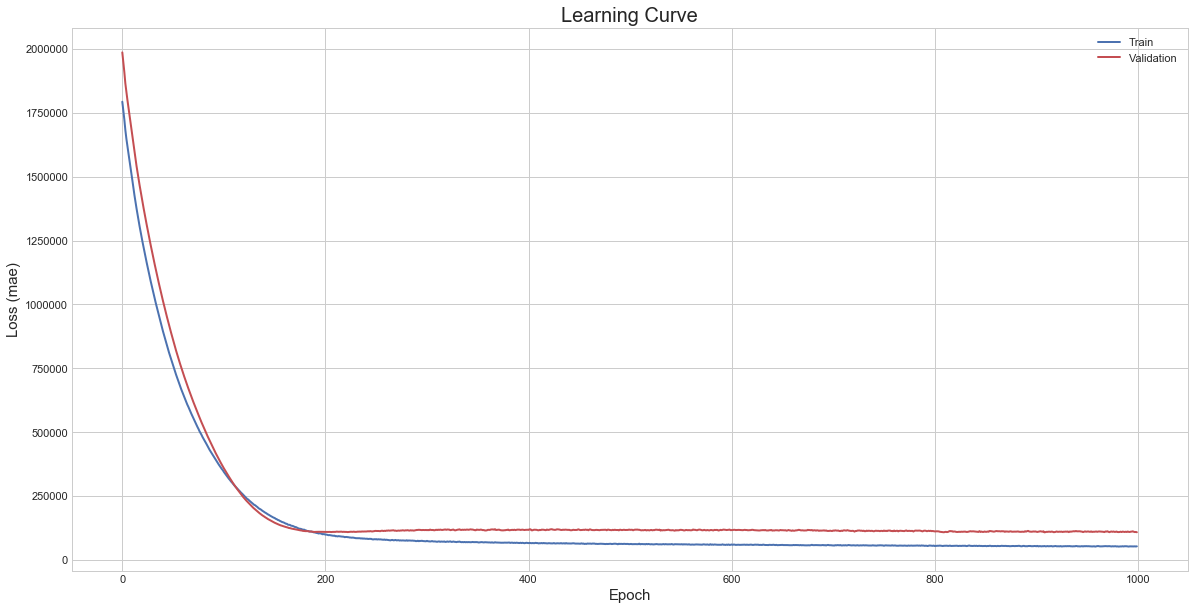

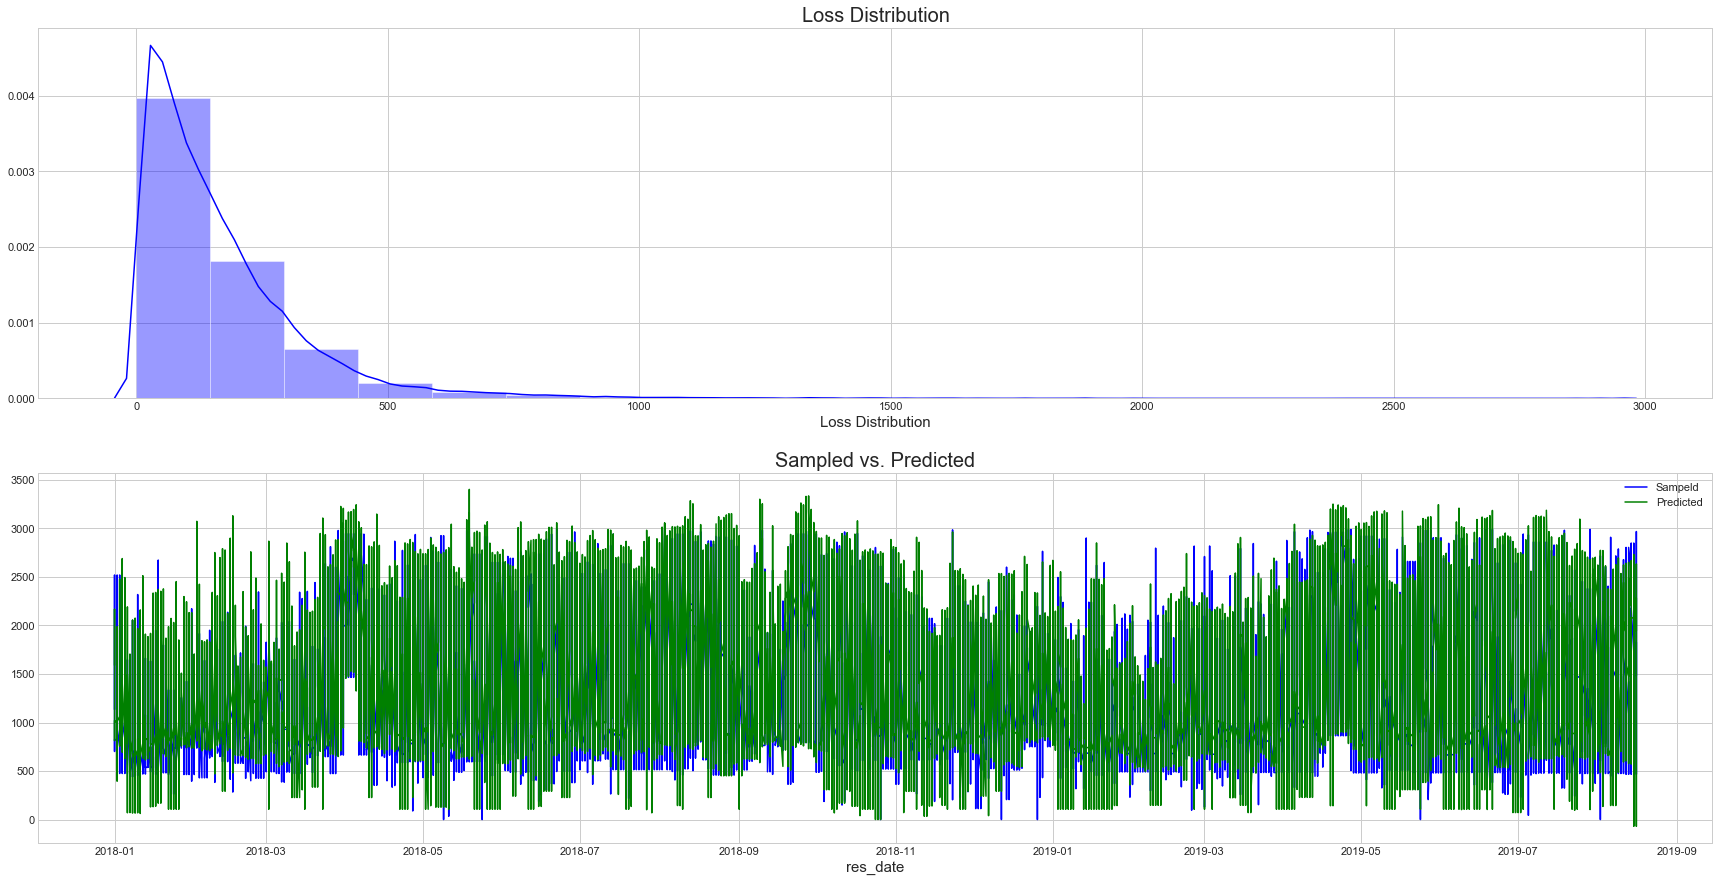

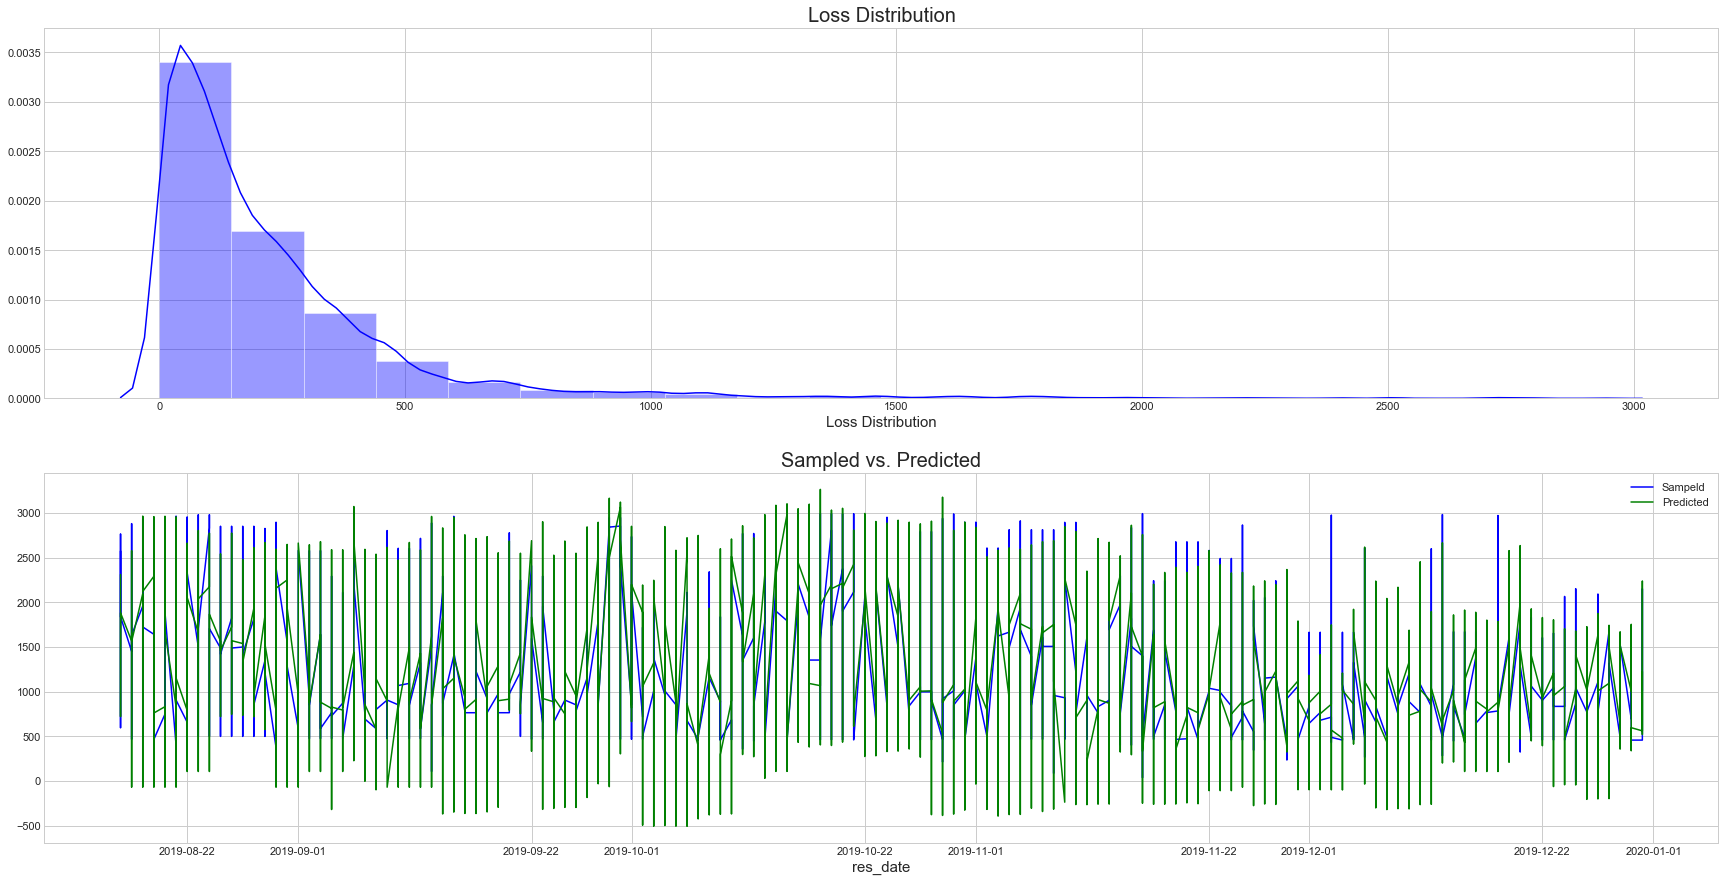

Train Accuracy: 0.83107 (loss MAE = 456.327)
Test Accuracy: 0.63088 (loss MAE = 215.898)


In [54]:
model_name = models[9]
print('Model: %s' % model_name)
model_file = save_path + "model_%s_h%d.h5" % (model_name, hotel_sel)

# Dataframe to Numpy array
X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()
y_train_np = y_train.to_numpy()
y_test_np = y_test.to_numpy()    

# Samples, TimeSteps, Features
X_train_shaped = X_train_np.reshape(X_train_np.shape[0], 1, X_train_np.shape[1])
X_test_shaped = X_test_np.reshape(X_test_np.shape[0], 1, X_test_np.shape[1])

# Samples, Features
y_train_shaped = y_train_np.reshape(y_train_np.shape[0], 1)
y_test_shaped = y_test_np.reshape(y_test_np.shape[0], 1)

if path.isfile(model_file) and not overwrite_saved_data:
    
    # Load an existing model
    model = load_model(model_file)
    history = joblib.load(model_file.replace('.h5','.pkl'))
    
else:
    
    # TensorFlow Initialization
    tf.compat.v1.set_random_seed(33)
    environ['PYTHONHASHSEED'] = str(33)
    np.random.seed(33)
    stacked_lstm = False
    n_nuerons = 128
    
    # Create the LSTM RNN model
    model = Sequential()
    if stacked_lstm:
        model.add(LSTM(n_nuerons, return_sequences=True, input_shape=(1, X_train.shape[1]), dropout=0.3))
        model.add(LSTM(n_nuerons/2, return_sequences=True, dropout=0.3))
        model.add(LSTM(n_nuerons/4, return_sequences=True, dropout=0.3))
        model.add(LSTM(n_nuerons/8, dropout=0.3))
    else:
        model.add(LSTM(n_nuerons, input_shape=(1, X_train.shape[1]), dropout=0.3))                      
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    
    # Fit the model to the data
    history = model.fit(X_train_shaped,
                        y_train_shaped,
                        epochs=1000, 
                        batch_size=512,
                        validation_split=0.05,
                        verbose=2).history
    
    # Save all model information, including weights, in h5 format
    model.save(model_file)
    print("Model saved (%s)" % model_file)

    # Save history to pickle
    joblib.dump(history, model_file.replace('.h5','.pkl'))

# Print Model summary
print(model.summary())

# Plot learning-curve
plot_learning_curve(history)

# Evaluate model:
(loss_mae_trn, X_true_trn, X_pred_trn, r2_trn) = lstm_calculate_loss(
    model, X_train_shaped, X_train.index, y_train_shaped)

(loss_mae_tst, X_true_tst, X_pred_tst, r2_tst) = lstm_calculate_loss(
    model, X_test_shaped, X_test.index, y_test_shaped)

# Save R2 results
if 'r2_train' not in history:
    history = joblib.load(model_file.replace('.h5','.pkl'))
    history['r2_train'] = r2_trn
    history['r2_test'] = r2_tst
    joblib.dump(history, model_file.replace('.h5','.pkl'))

# Calculate Accuracy
print('Train Accuracy: %.5f (loss MAE = %.3f)' % (r2_trn, loss_mae_trn.iloc[-1]))
print('Test Accuracy: %.5f (loss MAE = %.3f)' % (r2_tst, loss_mae_tst.iloc[-1]))

<hr>

### LSTM AutoEncoder (Tensorflow)

LSTM Autoencoders are composed by a simple LSTM encoder layer, followed by another simple LSTM decoder and by  TimeDistributed layer at the end.<br>
The idea here is to treat the dependant variable (y) as part of the features (X). We'll try to encode the whole set (Xy) and the decode it back.<br>
We will create a composite LSTM Autoencoder that has a single encoder and two decoders, one for reconstruction and one for prediction.<br>
<br>
<div><img src="https://miro.medium.com/max/1400/1*ZAorCoNenSYwDhTkFzqEGw.jpeg" width="500"/></div>

In [55]:
def autoencoder_calculate_loss(model, dataset, dataset_cols, dataset_idx, scaler_xy, plot_en=True):

    # Predict:
    Xpred = model.predict(dataset)
    Xpred = Xpred.reshape(Xpred.shape[0], Xpred.shape[1])
    Xpred = pd.DataFrame(Xpred, columns=dataset_cols)
    Xpred.index = dataset_idx

    # Ground Truth:
    Xtrue = dataset.reshape(dataset.shape[0], dataset.shape[1])
    Xtrue = pd.DataFrame(Xtrue, columns=dataset_cols)
    Xtrue.index = dataset_idx

    # Loss calculation:
    loss_mae = pd.DataFrame(index=dataset_idx)
    loss_mae = np.mean(np.abs(Xpred-Xtrue), axis=1)

    # UnScaling:
    Xy_dummy = dataset.copy()
    Xy_dummy = Xy_dummy.reshape(Xy_dummy.shape[0], Xy_dummy.shape[1])
    Xy_dummy = pd.DataFrame(Xy_dummy, columns=dataset_cols)
    Xy_dummy.index = dataset_idx
    Xy_dummy[dependent_var] = Xpred[dependent_var].values
    y_pred = scaler_xy.inverse_transform(Xy_dummy)[:, [-1]]
    Xy_dummy[dependent_var] = Xtrue[dependent_var].values
    y_true = scaler_xy.inverse_transform(Xy_dummy)[:, [-1]]
    
    # R2 score
    r2 = r2_score(Xtrue[dependent_var], Xpred[dependent_var])    
    
    # Plot:
    if plot_en:
        
        y_smp = pd.DataFrame(y_true, index=dataset_idx)
        y_prd = pd.DataFrame(y_pred, index=dataset_idx)

        y_smp_ma = y_smp.groupby(y_smp.index).mean().rolling(window=14).mean().fillna(0)
        y_prd_ma = y_prd.groupby(y_prd.index).mean().rolling(window=14).mean().fillna(0)

        y_ma = pd.concat([y_smp_ma, y_prd_ma], axis=1)
        y_ma.columns = ['Sampled', 'Predicted']
        
        fig, ax = plt.subplots(1, 1, figsize=(15,10))
        sns.distplot(loss_mae, bins=20, kde=True, color='blue', ax=ax)
        ax.set_title('Loss Distribution', fontsize=20)
        ax.set_xlabel('Loss Distribution', fontsize=15)
        #ax.set_xlim([0.0,.5])
        plt.show()

        fig, ax = plt.subplots(1, 1, figsize=(15,10))
        y_ma.plot(ax=ax, linewidth=1)
        ax.xaxis_date()
        ax.set_title('Sampled vs. Predicted (MA=14)')
        ax.set_xlabel('Time')
        ax.legend()
        fig.autofmt_xdate()        
        plt.show()
        
    return loss_mae, Xtrue, Xpred, r2

In [56]:
%%script false --no-raise-error

model_name = models[10]
print('Model: %s' % model_name)
model_file = save_path + "model_%s_h%d.h5" % (model_name, hotel_sel)

# Dataframe to Numpy array
X_train_np = Xy_train.to_numpy()
X_test_np = Xy_test.to_numpy()

# Reshape inputs for LSTM [samples, features, timesteps]
X_train_shaped = X_train_np.astype(np.float64).reshape(X_train_np.shape[0], X_train_np.shape[1], 1)
X_test_shaped = X_test_np.astype(np.float64).reshape(X_test_np.shape[0], X_test_np.shape[1], 1)

if path.isfile(model_file) and not overwrite_saved_data:
    
    # Load an existing model
    model = load_model(model_file)
    history = joblib.load(model_file.replace('.h5','.pkl'))
    
else:

    # TensorFlow Initialization
    tf.compat.v1.set_random_seed(33)
    environ['PYTHONHASHSEED'] = str(33)
    np.random.seed(33)

    sequence_length = 4

    session_conf = tf.compat.v1.ConfigProto(
        intra_op_parallelism_threads=1, 
        inter_op_parallelism_threads=1
    )
    sess = tf.compat.v1.Session(
        graph=tf.compat.v1.get_default_graph(), 
        config=session_conf
    )
    tf.compat.v1.keras.backend.set_session(sess)

    # Create the autoencoder model
    sequence_length = X_train_np.shape[1]
    inputs_ae = Input(shape=(sequence_length, 1))
    encoded_ae = LSTM(128, return_sequences=True, dropout=0.3)(inputs_ae, training=True)
    decoded_ae = LSTM(32, return_sequences=True, dropout=0.3)(encoded_ae, training=True)
    out_ae = TimeDistributed(Dense(1))(decoded_ae)

    model = Model(inputs_ae, out_ae)
    model.compile(optimizer='adam', loss='mse', metrics=['mse'])

    # Fit the model to the data
    history = model.fit(X_train_shaped,
                        X_train_shaped,
                        epochs=100,
                        batch_size=128,
                        validation_split=0.2,
                        verbose=2,
                        shuffle=True).history

    # Save all model information, including weights, in h5 format
    model.save(model_file)
    print("Model saved (%s)" % model_file)

    # Save history to pickle
    joblib.dump(history, model_file.replace('.h5','.pkl'))

# Print Model summary
print(model.summary())
    
# Plot learning-curve
plot_learning_curve(history)

# Evaluate model:
(loss_mae_trn, X_true_trn, X_pred_trn, r2_trn) = autoencoder_calculate_loss(
    model, X_train_shaped, Xy_train.columns, Xy_train.index, scaler_xy_train)

(loss_mae_tst, X_true_tst, X_pred_tst, r2_tst) = autoencoder_calculate_loss(
    model, X_test_shaped, Xy_test.columns, Xy_test.index, scaler_xy_test)

# Save R2 results
if 'r2_train' not in history:
    history = joblib.load(model_file.replace('.h5','.pkl'))
    history['r2_train'] = r2_trn
    history['r2_test'] = r2_tst
    joblib.dump(history, model_file.replace('.h5','.pkl'))

# Calculate Accuracy
print('Train Accuracy: (r2, loss MAE): %.5f, %.3f' % (r2_trn, loss_mae_trn.iloc[-1]))
print('Test Accuracy: (r2, loss MAE): %.5f, %.3f' % (r2_tst, loss_mae_tst.iloc[-1]))

### Forecasting

WIP

<hr>

# Statistical Forecasting

### SARIMAX

An ARIMA model is one where a time series get differenced d times to make it stationary, and then combine the AR and the MA terms.   
So the equation becomes:
<br>
<br>
$
\begin{align}
Y_t = \alpha + \beta_1Y_{t-1} + \beta_2Y_{t-2} + ... + \beta_pY_{t-p} + \epsilon_t + \phi_1\epsilon_{t-1} + \phi_2\epsilon_{t-2} + ... + \phi_q\epsilon_{t-q}
\end{align}
$
<br>
<br>
Linear regression models work best when the predictors are not correlated and are independent of each other.   
Hence, the first step to build an ARIMA model is to __make the time series stationary__.   
<br>
The __SARIMAX__ extension of ARIMA that explicitly models the seasonal element in univariate data.
<br>
<br>
There are three __trend elements__ (same as in the ARIMA model):
- p: Trend autoregression order
- d: Trend difference order
- q: Trend moving average order

There are four __seasonal elements__ (not part of ARIMA):
- P: Seasonal autoregressive order.
- D: Seasonal difference order.
- Q: Seasonal moving average order.
- m: The number of time steps for a single seasonal period.

In [57]:
def test_adf(series):
    '''
    Augmented Dickey-Fuller is the most popular statistical method to find if the series is stationary or not.
    It is also called as Unit Root Test.
    If value of p <0.05, then the data is stationary else the data is not stationary.
    '''
    
    dfout = {}
    dftest = sm.tsa.adfuller(series.dropna(), 
                             autolag='AIC', 
                             regression='ct')
    
    for key,val in dftest[4].items():
        dfout[f'critical value ({key})'] = val
    
    adf_p_value = dftest[1]
    
    is_stationary = adf_p_value <= 0.05
    
    if is_stationary:
        print("Strong evidence against Null Hypothesis")
        print("Reject Null Hypothesis - Data is Stationary")
        print("Data is Stationary (p=%.5f)" % adf_p_value)
    else:
        print("Strong evidence for  Null Hypothesis")
        print("Accept Null Hypothesis - Data is not Stationary")
        print("Data is NOT Stationary (p=%.2f) for " % adf_p_value)
    
    return is_stationary

Strong evidence against Null Hypothesis
Reject Null Hypothesis - Data is Stationary
Data is Stationary (p=0.00000)
Model: sarima
(p,d,q) = (2, 0, 1)
(P,D,Q,s) = (0, 0, 0, 1)
AIC = -60592.62


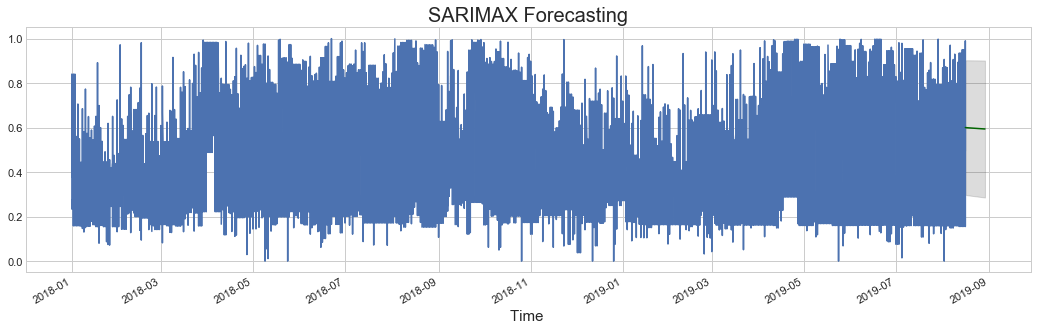

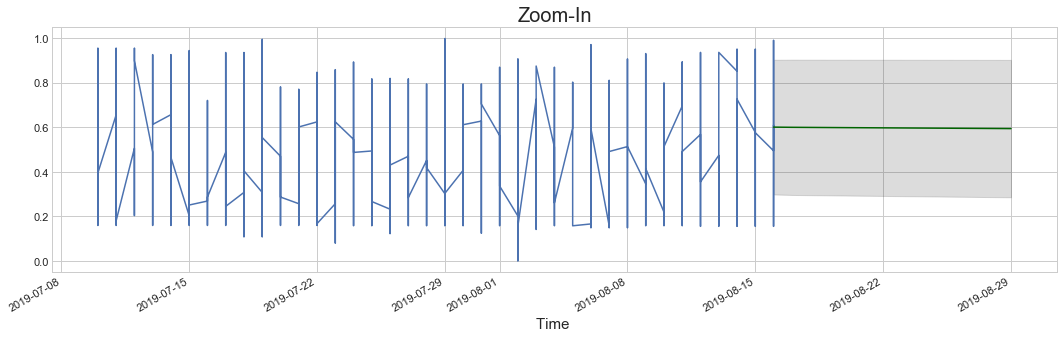

In [58]:
n_periods = 14  # amount of future time-samples to predict
n_zoom_in = 4000  # plotting zoom-in (last 'n_zoom_in' time-samples) 

# Normalization
sc_in = MinMaxScaler(feature_range=(0, 1))
out = pd.DataFrame(sc_in.fit_transform(pd.DataFrame(y_train)))
out.rename(columns={0:dependent_var}, inplace=True)

# Stationarity check
is_stationary = test_adf(out[dependent_var])
if not is_stationary:
    test_adf(out.diff())
    
model_name = models[11]
print('Model: %s' % model_name)
model_file = save_path + "model_%s_h%d.pkl" % (model_name, hotel_sel)

if path.isfile(model_file) and not overwrite_saved_data:
    
    # Load an existing model
    model = joblib.load(model_file)
    
else:

    # Create the arima model + Auto Fit:
    model = auto_arima(out,
                       start_p=1,        # min_p (AR term)
                       start_q=1,        # min_q (MA term)
                       test='adf',       # use ADF test to find optimal 'd'
                       max_p=3,          # max p (AR term)
                       max_q=3,          # max q (MA term)
                       m=1,              # frequency of series
                       d=None,           # let model determine 'd'
                       seasonal=True,    # True for SARIMAX, False for No Seasonality
                       start_P=0,        # min_P (AR term of the seasonal model)
                       D=None,           # let model determine 'D'
                       trace=False,
                       error_action='ignore',  
                       suppress_warnings=True, 
                       stepwise=True)

    # Save the model
    joblib.dump(model, model_file)

print('(p,d,q) = %s' % str(model.get_params()['order']))
print('(P,D,Q,s) = %s' % str(model.get_params()['seasonal_order']))        
print('AIC = %.2f' % model.aic())

out.index = y_train.index

# Forecast
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)

# Make series for plotting purpose
fc_series = pd.Series(fc, index=pd.date_range(start=out.index[-1], periods=n_periods, freq='D'))

lower_series = pd.Series(confint[:, 0], index=fc_series.index)
upper_series = pd.Series(confint[:, 1], index=fc_series.index)

# Plot
fig, ax = plt.subplots(1, 1, figsize=(18,5))
ax.set_title('SARIMAX Forecasting', fontsize=20)
ax.set_xlabel('Time ', fontsize=15)
ax.plot(out)
ax.plot(fc_series, color='darkgreen')
ax.xaxis_date()
ax.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
fig.autofmt_xdate()
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(18,5))
ax.set_title('Zoom-In', fontsize=20)
ax.set_xlabel('Time ', fontsize=15)
ax.plot(out[-n_zoom_in:])
ax.plot(fc_series, color='darkgreen')
ax.xaxis_date()
ax.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
fig.autofmt_xdate()
plt.show()

### FBProphet

[Facebook Prophet](https://facebook.github.io/prophet/) is an additive regression model with four main components:
- A piecewise linear or logistic growth curve trend. Prophet automatically detects changes in trends by selecting changepoints from the data.
- A yearly seasonal component modeled using Fourier series.
- A weekly seasonal component using dummy variables.
- A user-provided list of important holidays.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Model: fbprophet


/usr/local/lib/python3.7/site-packages/fbprophet/forecaster.py:400: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.



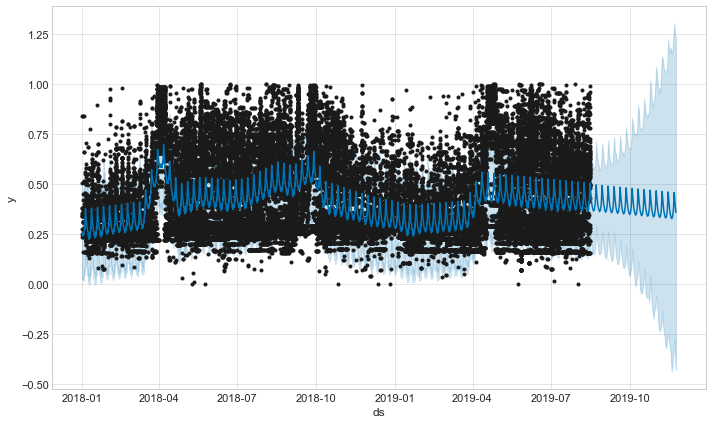

In [59]:
# Change the column names according to Prophet's guidelines:
out_df = out.copy().reset_index()
out_df.columns = ['ds', 'y']
out_df.T

# Split into a train/test set:
prediction_size = 100
train_df = out_df[:-prediction_size]

# Build an Prophet model:
model_name = "fbprophet"
print('Model: %s' % model_name)
model_file = save_path + "model_%s_h%d.pkl" % (model_name, hotel_sel)

if path.isfile(model_file) and not overwrite_saved_data:
    
    # Load an existing model
    model = joblib.load(model_file)

else:

    model = Prophet()
    model.fit(train_df)
    
    # Save the model
    joblib.dump(model, model_file)
        
# Forecast:
future_df = model.make_future_dataframe(periods=prediction_size)
forecast_df = model.predict(future_df)
forecast_df.head()

# Plot forecast
model.plot(forecast_df)
plt.show()

# Plot forecast components:
#model.plot_components(forecast_df)
#plt.show()

<hr>

# Summary

In [60]:
summary = { 'train_accuracy': {}, 
            'test_accuracy': {} } 

for model_name in models:
    
    if model_name == 'sarima' or model_name == 'fbprophet' or model_name == 'lstm_autoencoder':
        continue
    
    model_file = save_path + "model_%s_h%d.pkl" % (model_name, hotel_sel)

    if path.isfile(model_file):
        
        model = joblib.load(model_file)
        
        if type(model) is dict:
            summary['train_accuracy'][model_name] = model['r2_train']
            summary['test_accuracy'][model_name] = model['r2_test']
        else:
            summary['train_accuracy'][model_name] = model.score(X_train, y_train)
            summary['test_accuracy'][model_name] = model.score(X_test, y_test)
    
    else:
        print("Skipping: %s" % model_file)
          
summary_df = pd.DataFrame(summary).astype(float).round(4)
summary_df[abs(summary_df)>1] = 0
display(summary_df)

,train_accuracy,test_accuracy
linear_regressor,0.8201,0.0000
ridge_regressor,0.8206,0.8253
lasso_regressor,0.8206,0.8160
elasticnet_regressor,0.7999,0.7673
supportvect_regressor,0.8136,0.7074
decisiontree_regressor,0.9999,0.5723
randomforest_regressor,0.6272,0.5758
xgboost_regressor,0.8528,0.8129
mlp_regressor,0.9445,0.0000
lstm_rnn,0.8311,0.6309


<hr>

In [61]:
print('Completed')

Completed
